In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
import gensim
from tqdm import tqdm
import sklearn.cluster
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
from datetime import datetime
import seaborn as sns

Download Toys_and_Games_with_scores.csv from the Google Drive

In [2]:
data_clean = pd.read_csv('Toys_and_Games_with_scores.csv')

Methods to be used later in the analysis

In [3]:
# SVO extraction
nlp = spacy.load("en_core_web_sm")
OBJECT_DEPS = {"dobj", "dative", "attr", "oprd"}
SUBJECT_DEPS = {"nsubj", "nsubjpass", "csubj", "agent", "expl"}
def extract_svo(doc, sub, at, ve):
    for token in doc:
        if token.pos_ == "VERB":
            ve.append(token.text)
        if token.dep_ in OBJECT_DEPS or token.head.dep_ in OBJECT_DEPS:
            at.append(token.text)
        if token.dep_ in SUBJECT_DEPS or token.head.dep_ in SUBJECT_DEPS:
            sub.append(token.text)
# Topic modeling
def create_topic_model(word_list, n):
    id2word = corpora.Dictionary(word_list)
    texts = word_list
    corpus = [id2word.doc2bow(text) for text in texts]
    num_topics = n
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)
    doc_lda = lda_model[corpus]
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join('/Users/clairefenton/Downloads/ldavis_prepared_'+str(num_topics))
    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, '/Users/clairefenton/Downloads/ldavis_prepared_'+ str(num_topics) +'.html')
    LDAvis_prepared

Summary statistics (positive, negative and compound are from sentiment analysis scores)

In [4]:
data_clean.describe()[['overall', 'vote', 'Positive', 'Negative', 'Compound']]

,overall,vote,Positive,Negative,Compound
count,1.820811e+06,1.820811e+06,1.820811e+06,1.820811e+06,1.820811e+06
mean,4.474145e+00,8.643731e-01,4.773773e-01,4.027191e-02,6.496184e-01
std,9.992829e-01,8.487899e+00,2.576863e-01,8.818910e-02,3.460533e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.998000e-01
25%,4.000000e+00,0.000000e+00,2.990000e-01,0.000000e+00,5.106000e-01
50%,5.000000e+00,0.000000e+00,4.570000e-01,0.000000e+00,7.645000e-01
75%,5.000000e+00,0.000000e+00,6.550000e-01,4.900000e-02,9.042000e-01
max,5.000000e+00,1.973000e+03,1.000000e+00,1.000000e+00,1.000000e+00


What percentage of the reviews belong to each score category?

In [5]:
data_clean['overall'].value_counts()/len(data_clean) * 100

overall
5    71.306522
4    14.909565
3     7.137479
1     3.461644
2     3.184790
Name: count, dtype: float64

In [6]:
print('Number of reviews: ', len(data_clean))
print('Number of items: ', len(data_clean['asin'].unique()))
print('Average rating: ', data_clean['overall'].mean())
print('Percentage of reviews that are verified: ', data_clean['verified'].sum()/len(data_clean) * 100)
print('Average number of votes: ', data_clean['vote'].mean())

Number of reviews:  1820811
Number of items:  78771
Average rating:  4.474145312171335
Percentage of reviews that are verified:  87.44553937778275
Average number of votes:  0.8643730733173295


Score distribution for the whole data set.

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/622594997.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Reviews by Review Rating Across All Products')

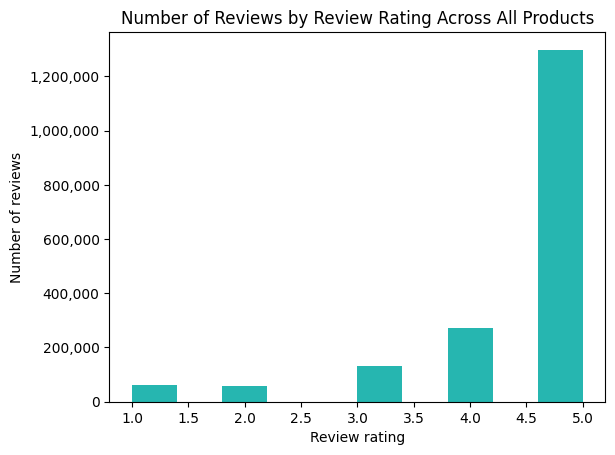

In [7]:
plt.hist(data_clean['overall'], color='#26b6b0')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Review rating')
plt.ylabel('Number of reviews')
plt.title('Number of Reviews by Review Rating Across All Products')

FIRST QUESTION: Is the counterfeit issue real?

IDEA: Items that have the majority (i.e. over 50%) of their reviews being negative are likely counterfeit given that the overall data set has extremely high ratings. Items consistently rated low should are anomalies and should counterfeit. 

In [8]:
neg = data_clean[data_clean['overall'] < 3].groupby('asin').count()['Unnamed: 0']
comp = data_clean[data_clean['asin'].isin(neg.index)].groupby('asin').count()['Unnamed: 0'].values
d = {'asin': neg.index, 'neg': neg.values, 'comp': comp}
df = pd.DataFrame(data=d)
df['ratio'] = df['neg']/df['comp']
test = data_clean[data_clean['asin'].isin(df[df['ratio'] > .5]['asin'].values)]

Distribution of the proportion of negative reviews for the items across the whole data set

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/1137244585.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Products by Proportion of Negative Reviews Across All Products')

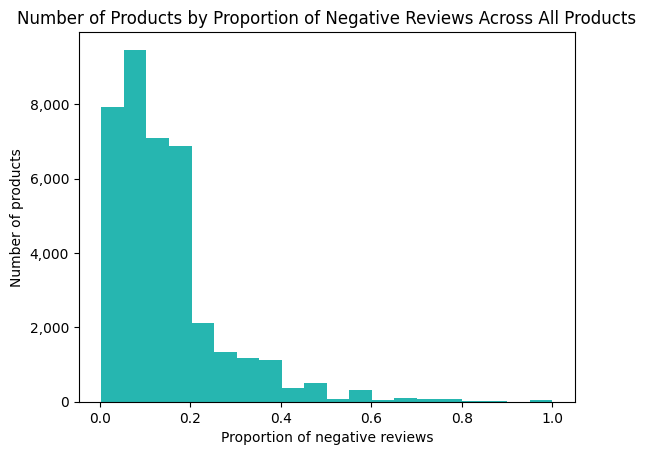

In [9]:
plt.hist(df['ratio'], color='#26b6b0', bins=20)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Proportion of negative reviews')
plt.ylabel('Number of products')
plt.title('Number of Products by Proportion of Negative Reviews Across All Products')

Only around 26% of ratings for these potentially counterfeit items are "good" (i.e. better than 3)...

In [10]:
test['overall'].value_counts()/len(test) * 100

overall
1    42.596084
2    20.681653
5    18.883249
3     9.064540
4     8.774474
Name: count, dtype: float64

... compared to 86% in the whole data set.

In [11]:
data_clean['overall'].value_counts()/len(data_clean) * 100

overall
5    71.306522
4    14.909565
3     7.137479
1     3.461644
2     3.184790
Name: count, dtype: float64

In [12]:
print('Number of counterfeit items: ', len(test['asin'].unique()))
print('Number of reviews associated with those items: ', len(test))
print('Average overall score: ', test['overall'].mean())
print('Proportion of reviews that are verified: ', test['verified'].sum()/len(test) * 100)
print('Proportion of overall items: ', len(test['asin'].unique())/len(data_clean['asin'].unique()) * 100)
print('Proportion of overall reviews: ', len(test)/len(data_clean) * 100)

Number of counterfeit items:  727
Number of reviews associated with those items:  6895
Average overall score:  2.406671501087745
Proportion of reviews that are verified:  69.07904278462654
Proportion of overall items:  0.9229284889108936
Proportion of overall reviews:  0.37867741352617046


Looking at SVO (subject, verb, object) extraction for the counterfeit toys.

**Note: "doe" is likely an incorrectly parsed form of "does" and "wa" an incorrectly parsed form of "was"

In [13]:
sub = []
at = []
ve = []
df = test
for i in range(len(df)):
    doc = nlp(df['cleaned_summary'].iloc[i])
    extract_svo(doc, sub, at, ve)

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/1577802804.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Reviews for Counterfeit Products Over Time')

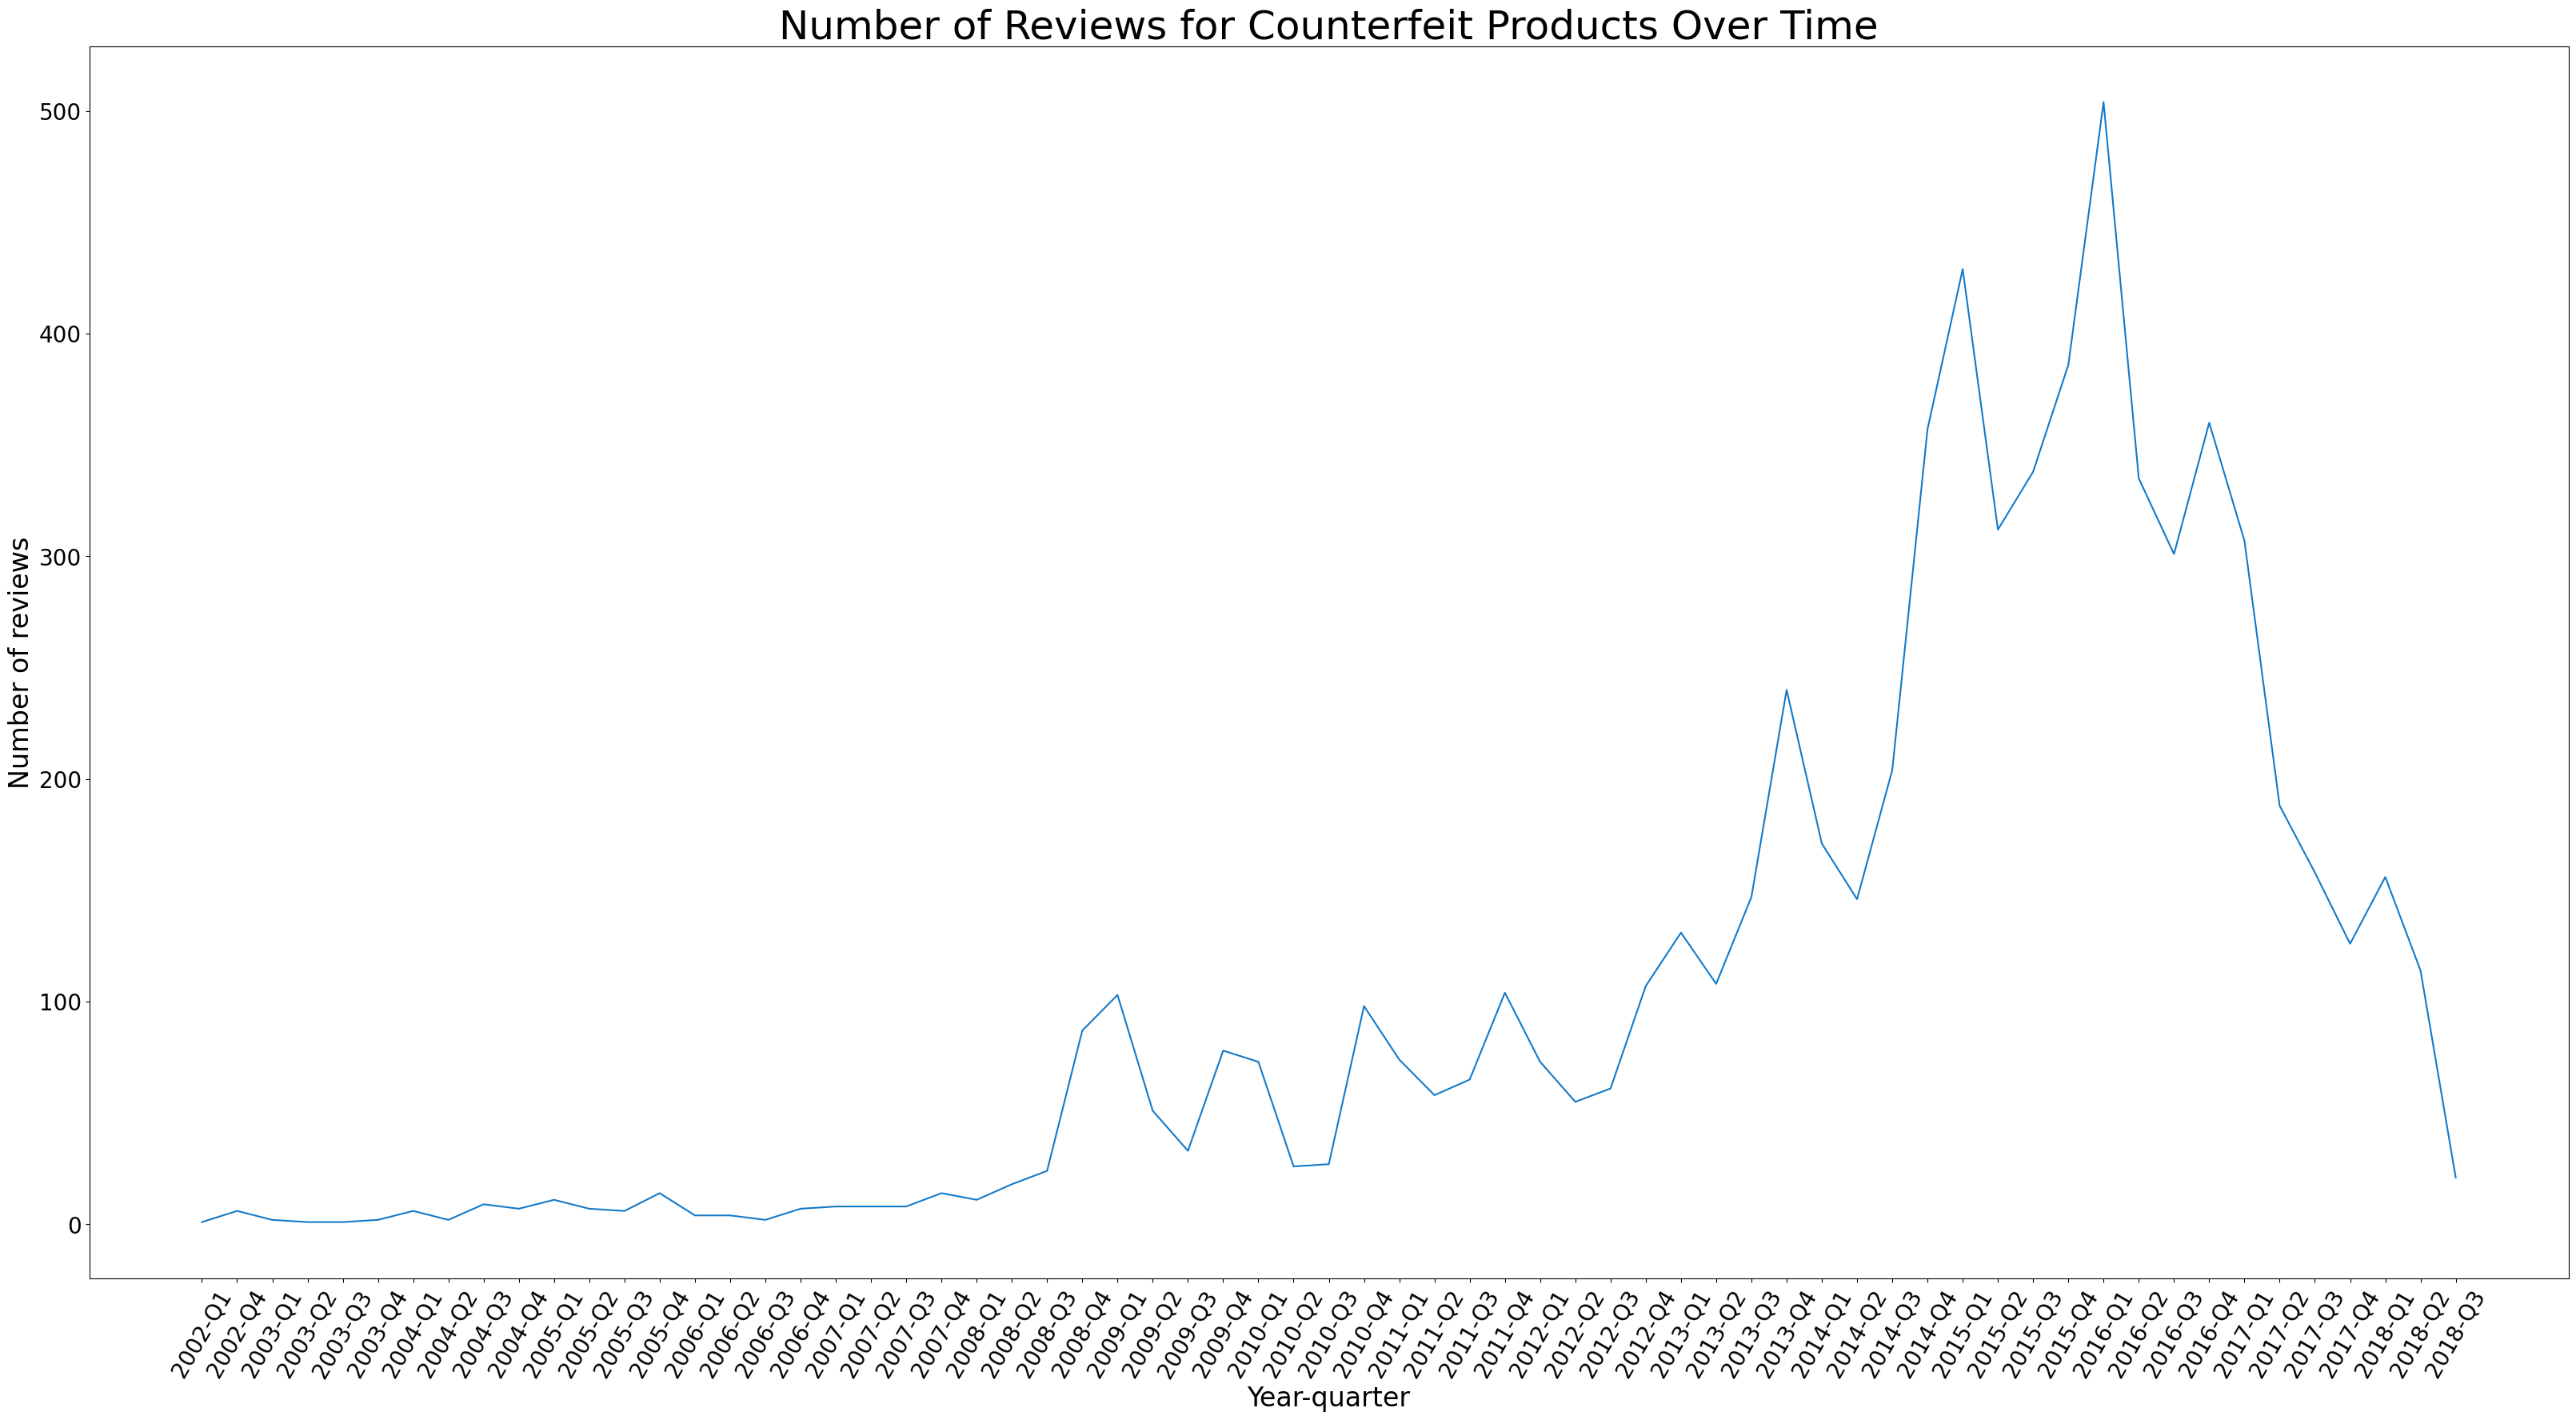

In [14]:
plt.figure(figsize = (40, 20))
plt.plot(test['year-q'].value_counts().sort_index().index, test['year-q'].value_counts().sort_index().values, color='#1379c8', label='Counterfeit')
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Year-quarter', fontdict={'size': 24})
plt.ylabel('Number of reviews', fontdict={'size': 24})
plt.title('Number of Reviews for Counterfeit Products Over Time', fontdict={'size': 36})

In [16]:
real_hasbro = data_clean[-data_clean['asin'].isin(test['asin'].unique())]

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/2243785864.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Reviews for Hasbro Products Over Time')

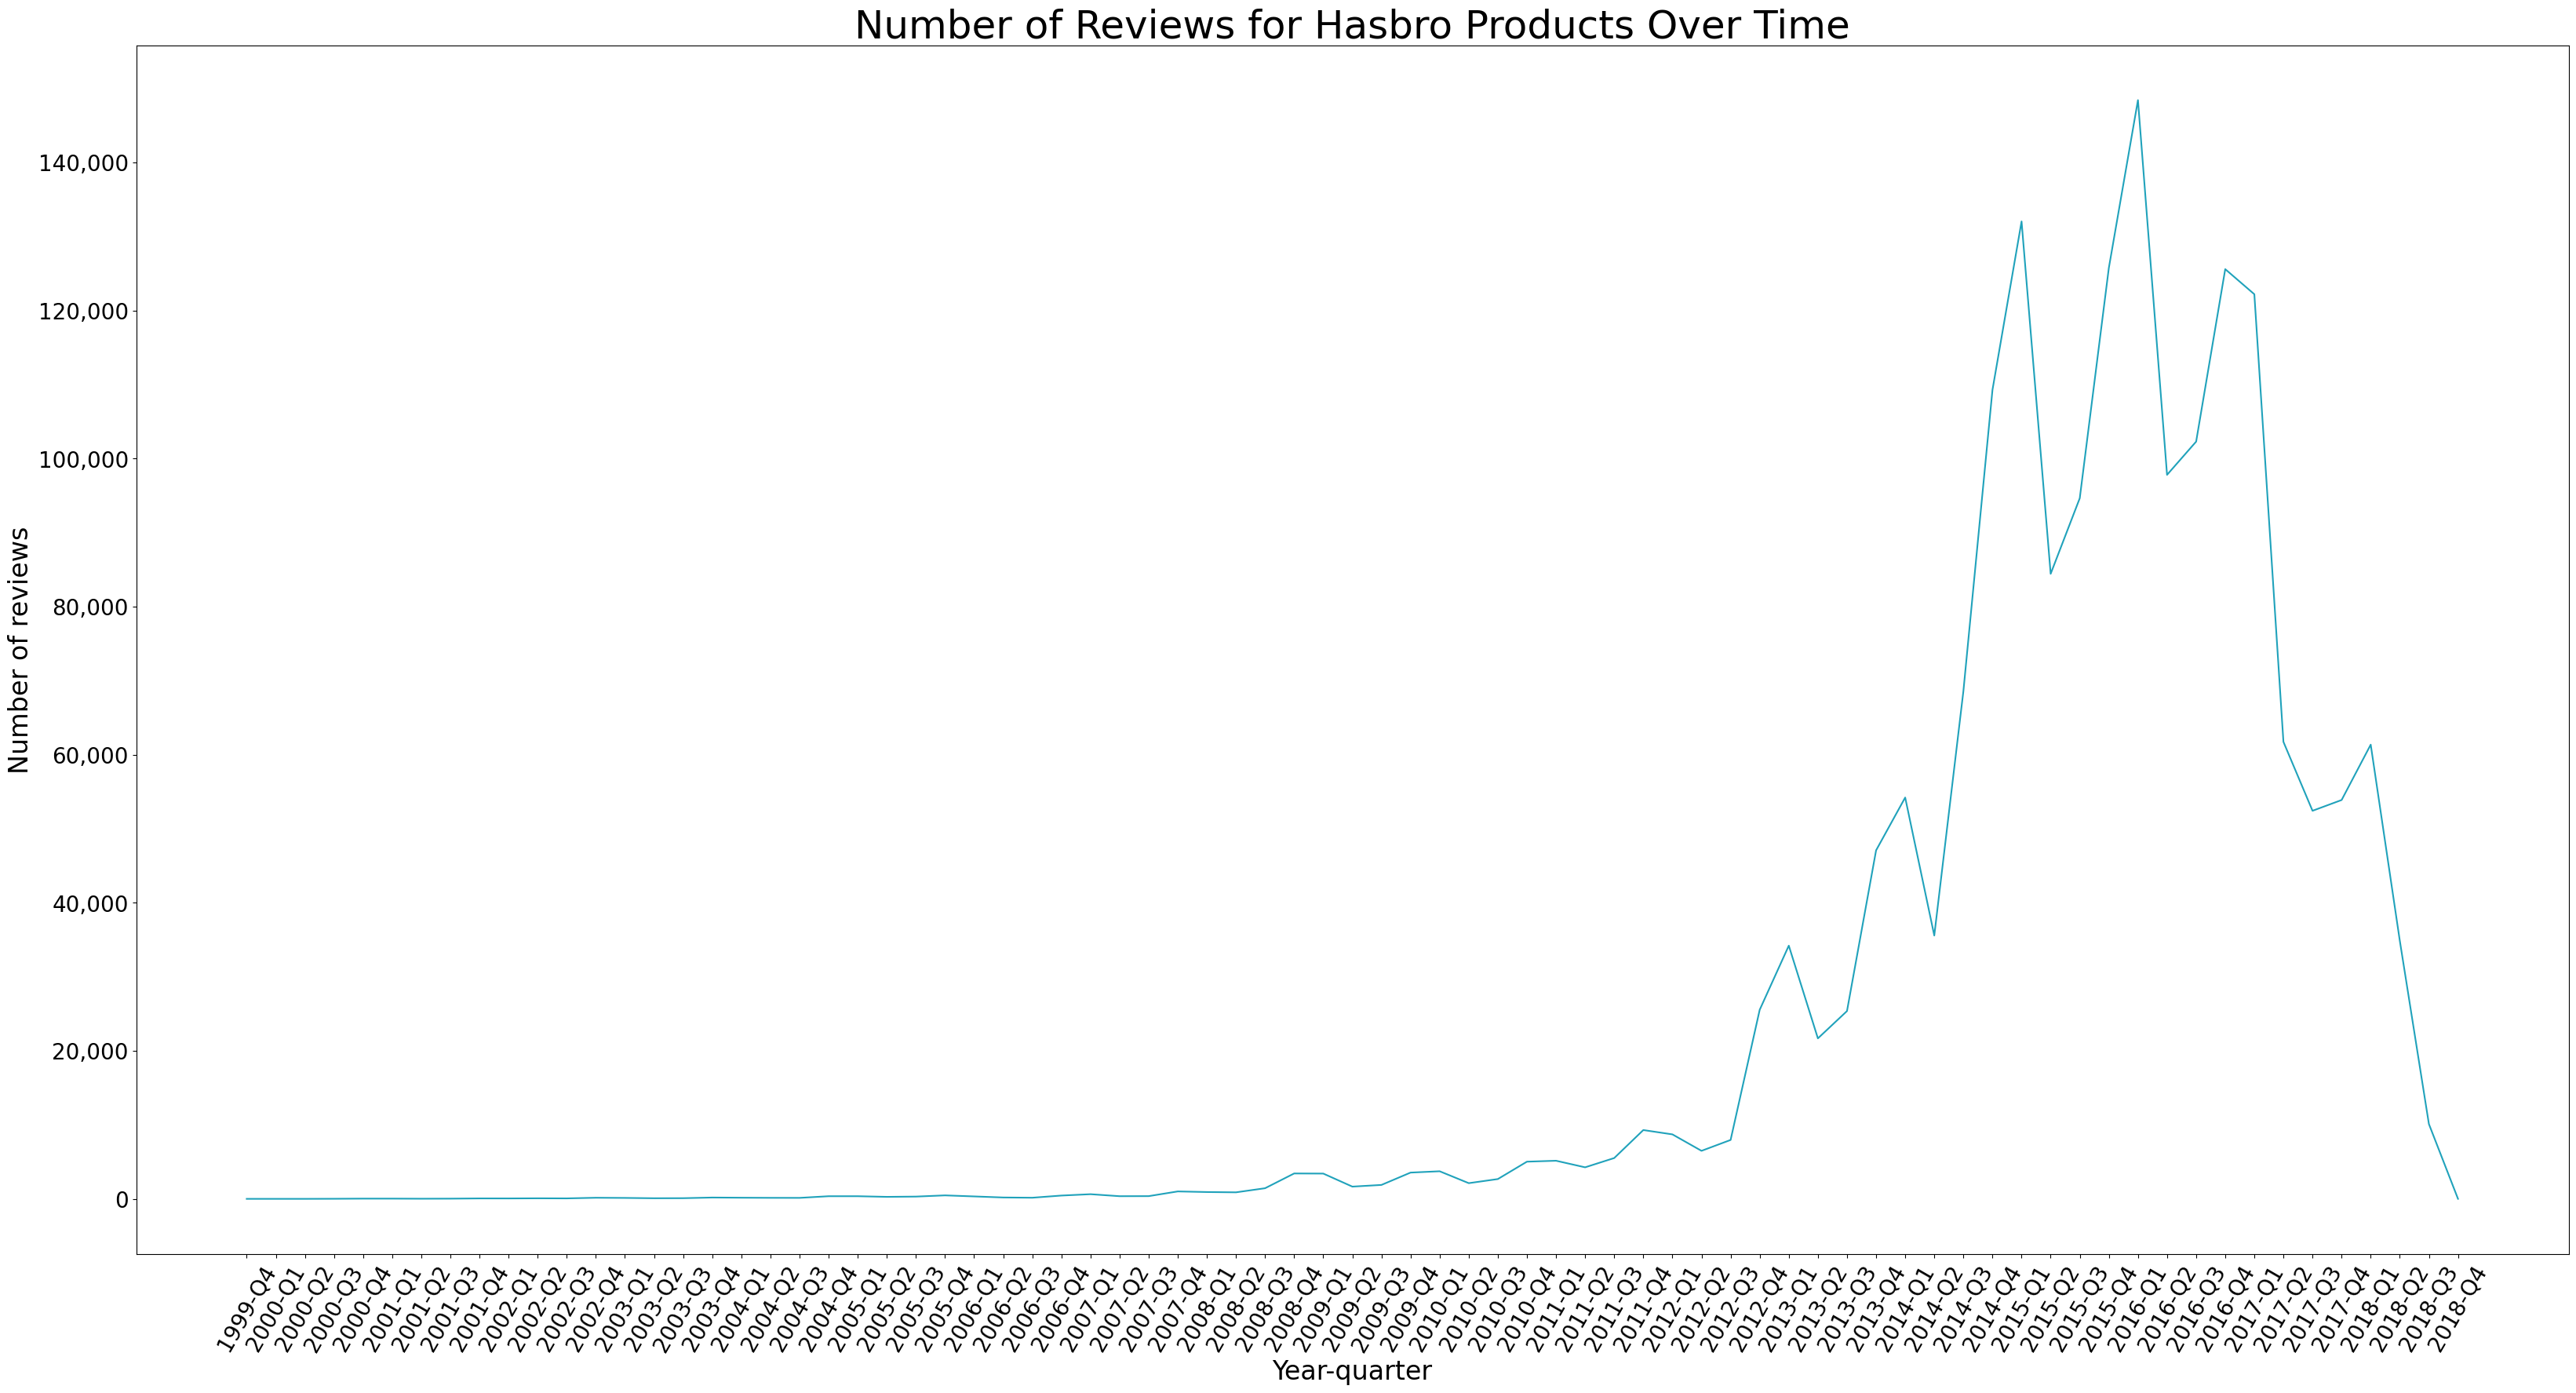

In [17]:
plt.figure(figsize = (40, 20))
plt.plot(real_hasbro['year-q'].value_counts().sort_index().index, real_hasbro['year-q'].value_counts().sort_index().values, color='#20a2bb', label='Hasbro')
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Year-quarter', fontdict={'size': 24})
plt.ylabel('Number of reviews', fontdict={'size': 24})
plt.title('Number of Reviews for Hasbro Products Over Time', fontdict={'size': 36})

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/3596615356.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


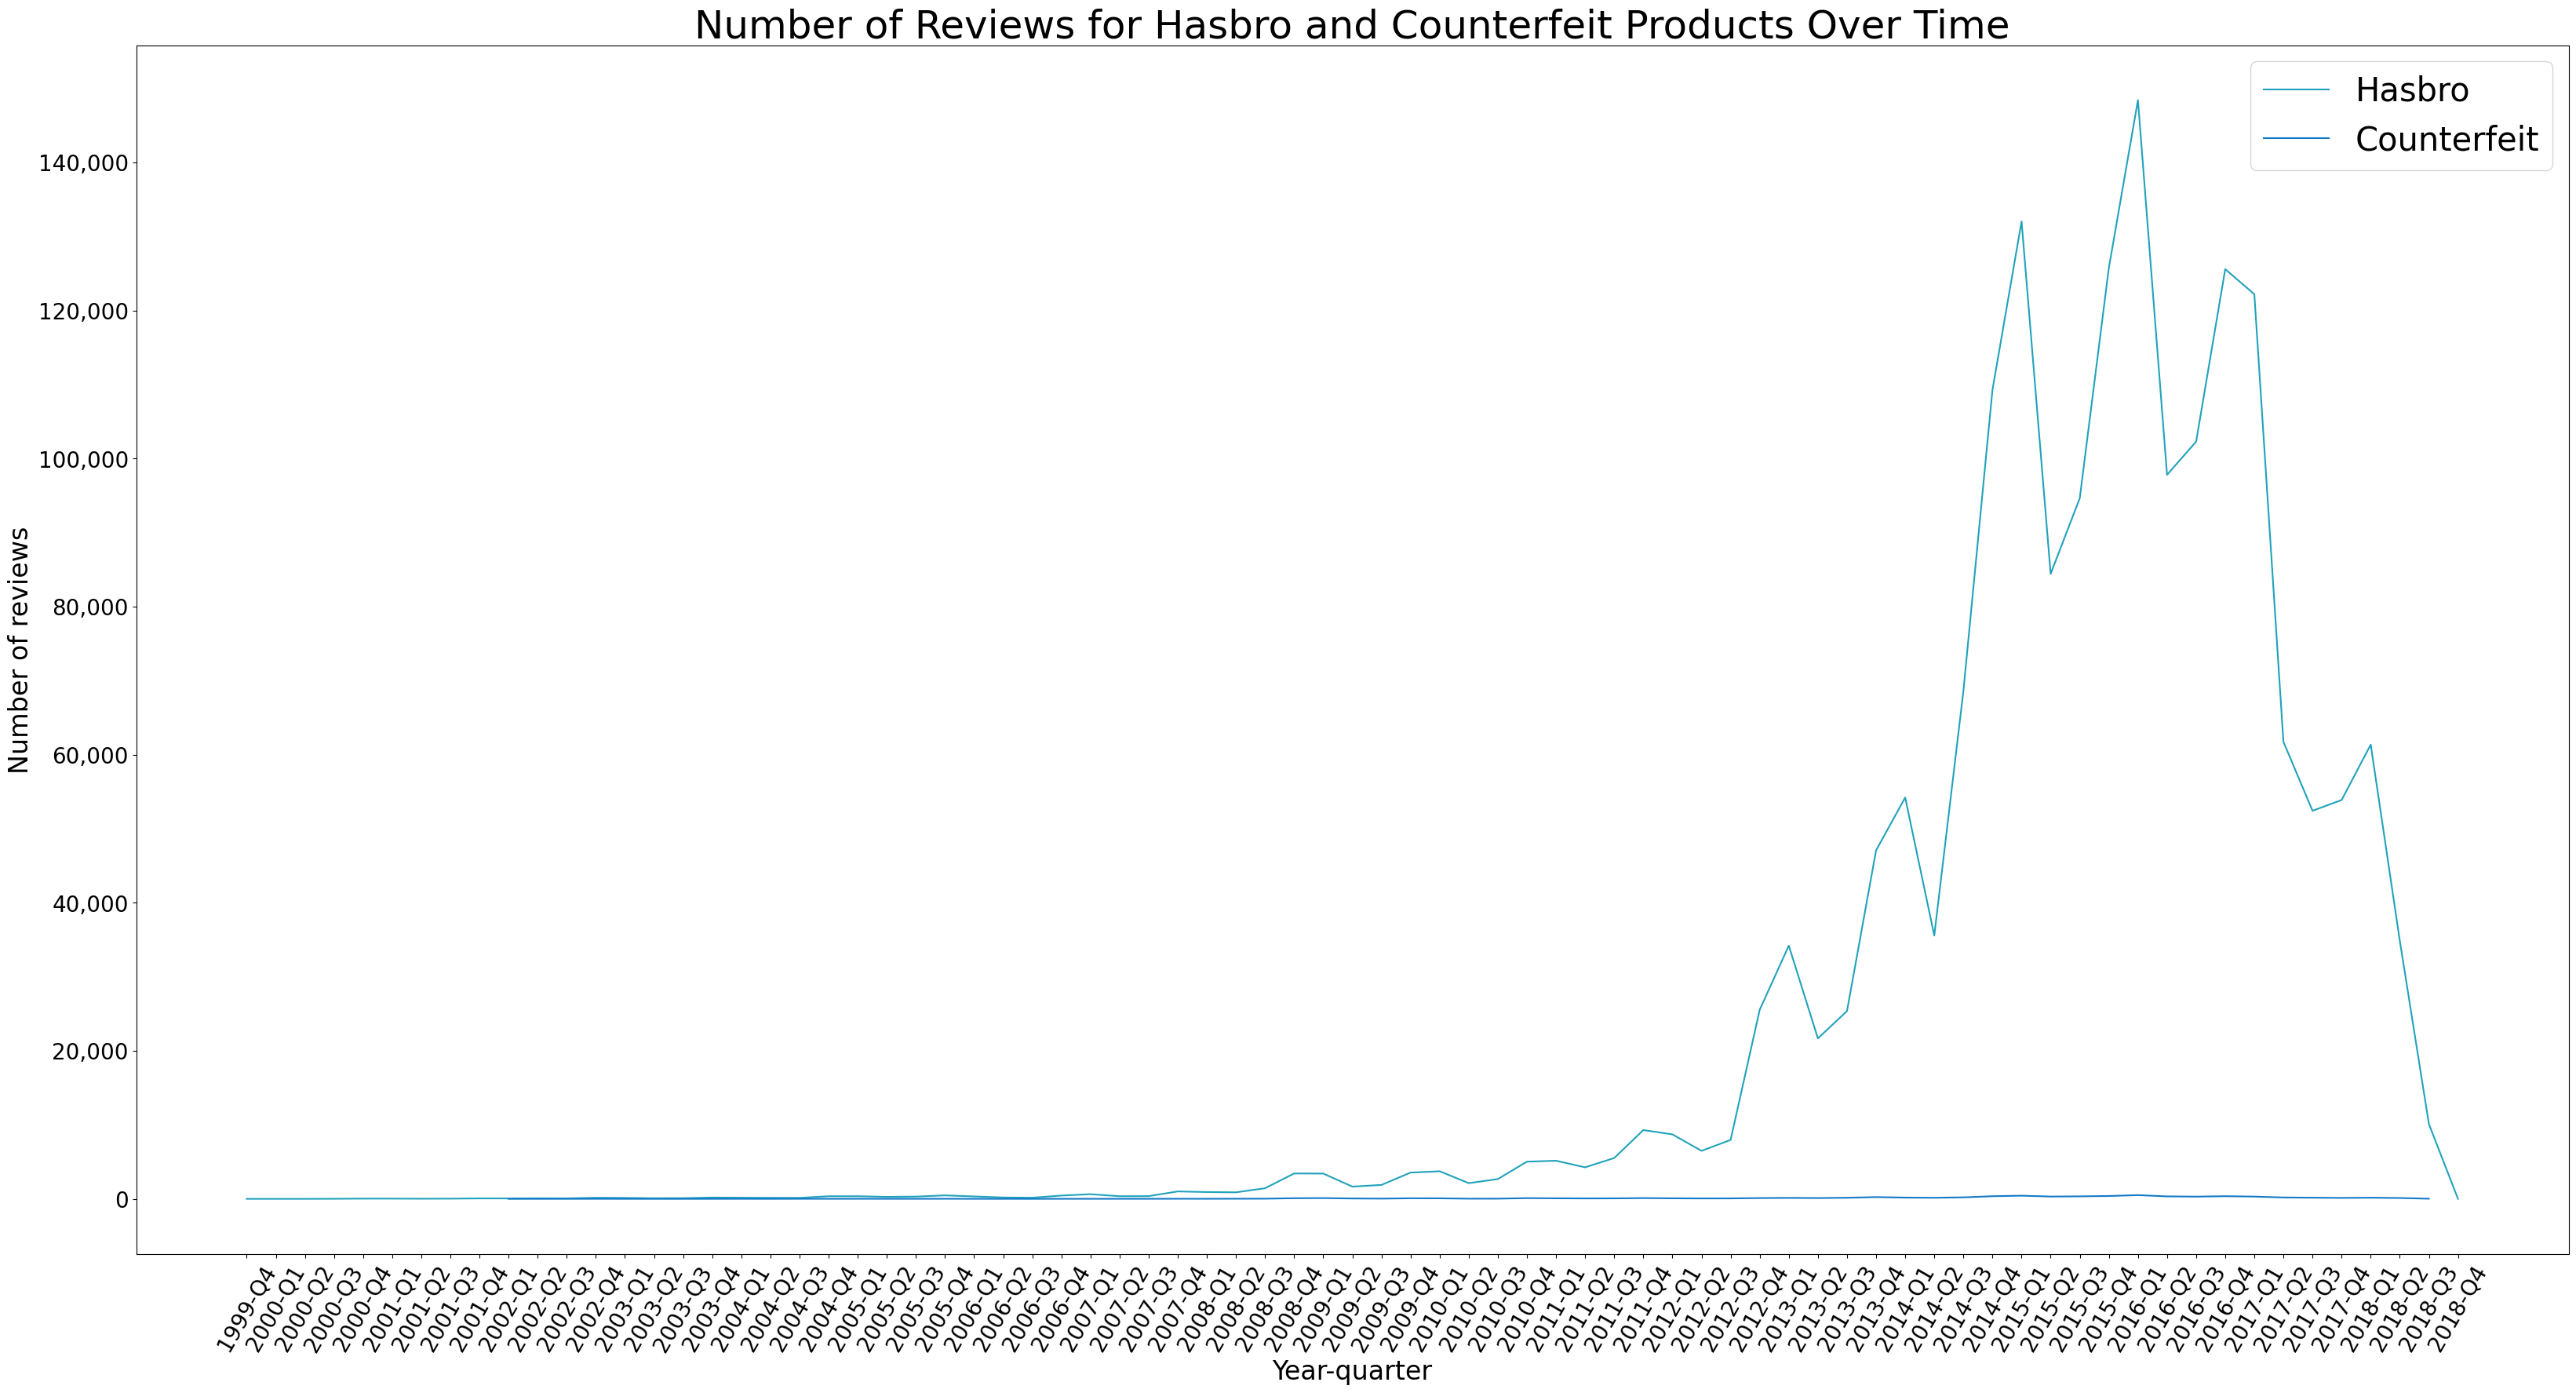

In [18]:
plt.figure(figsize = (40, 20))
plt.plot(real_hasbro['year-q'].value_counts().sort_index().index, real_hasbro['year-q'].value_counts().sort_index().values, color='#20a2bb', label='Hasbro')
plt.plot(test['year-q'].value_counts().sort_index().index, test['year-q'].value_counts().sort_index().values, color='#1379c8', label='Counterfeit')
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Year-quarter', fontdict={'size': 24})
plt.ylabel('Number of reviews', fontdict={'size': 24})
plt.title('Number of Reviews for Hasbro and Counterfeit Products Over Time', fontdict={'size': 36})
plt.legend(fontsize=30)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64],
 [Text(0, 0, '2002-Q1'),
  Text(1, 0, '2002-Q4'),
  Text(2, 0, '2003-Q1'),
  Text(3, 0, '2003-Q2'),
  Text(4, 0, '2003-Q3'),
  Text(5, 0, '2003-Q4'),
  Text(6, 0, '2004-Q1'),
  Text(7, 0, '2004-Q2'),
  Text(8, 0, '2004-Q3'),
  Text(9, 0, '2004-Q4'),
  Text(10, 0, '2005-Q1'),
  Text(11, 0, '2005-Q2'),
  Text(12, 0, '2005-Q3'),
  Text(13, 0, '2005-Q4'),
  Text(14, 0, '2006-Q1'),
  Text(15, 0, '2006-Q2'),
  Text(16, 0, '2006-Q3'),
  Text(17, 0, '2006-Q4'),
  Text(18, 0, '2007-Q1'),
  Text(19, 0, '2007-Q2'),
  Text(20, 0, '2007-Q3'),
  Text(21, 0, '2007-Q4'),
  Text(22, 0, '2008-Q1'),
  Text(23, 0, '2008-Q2'),
  Tex

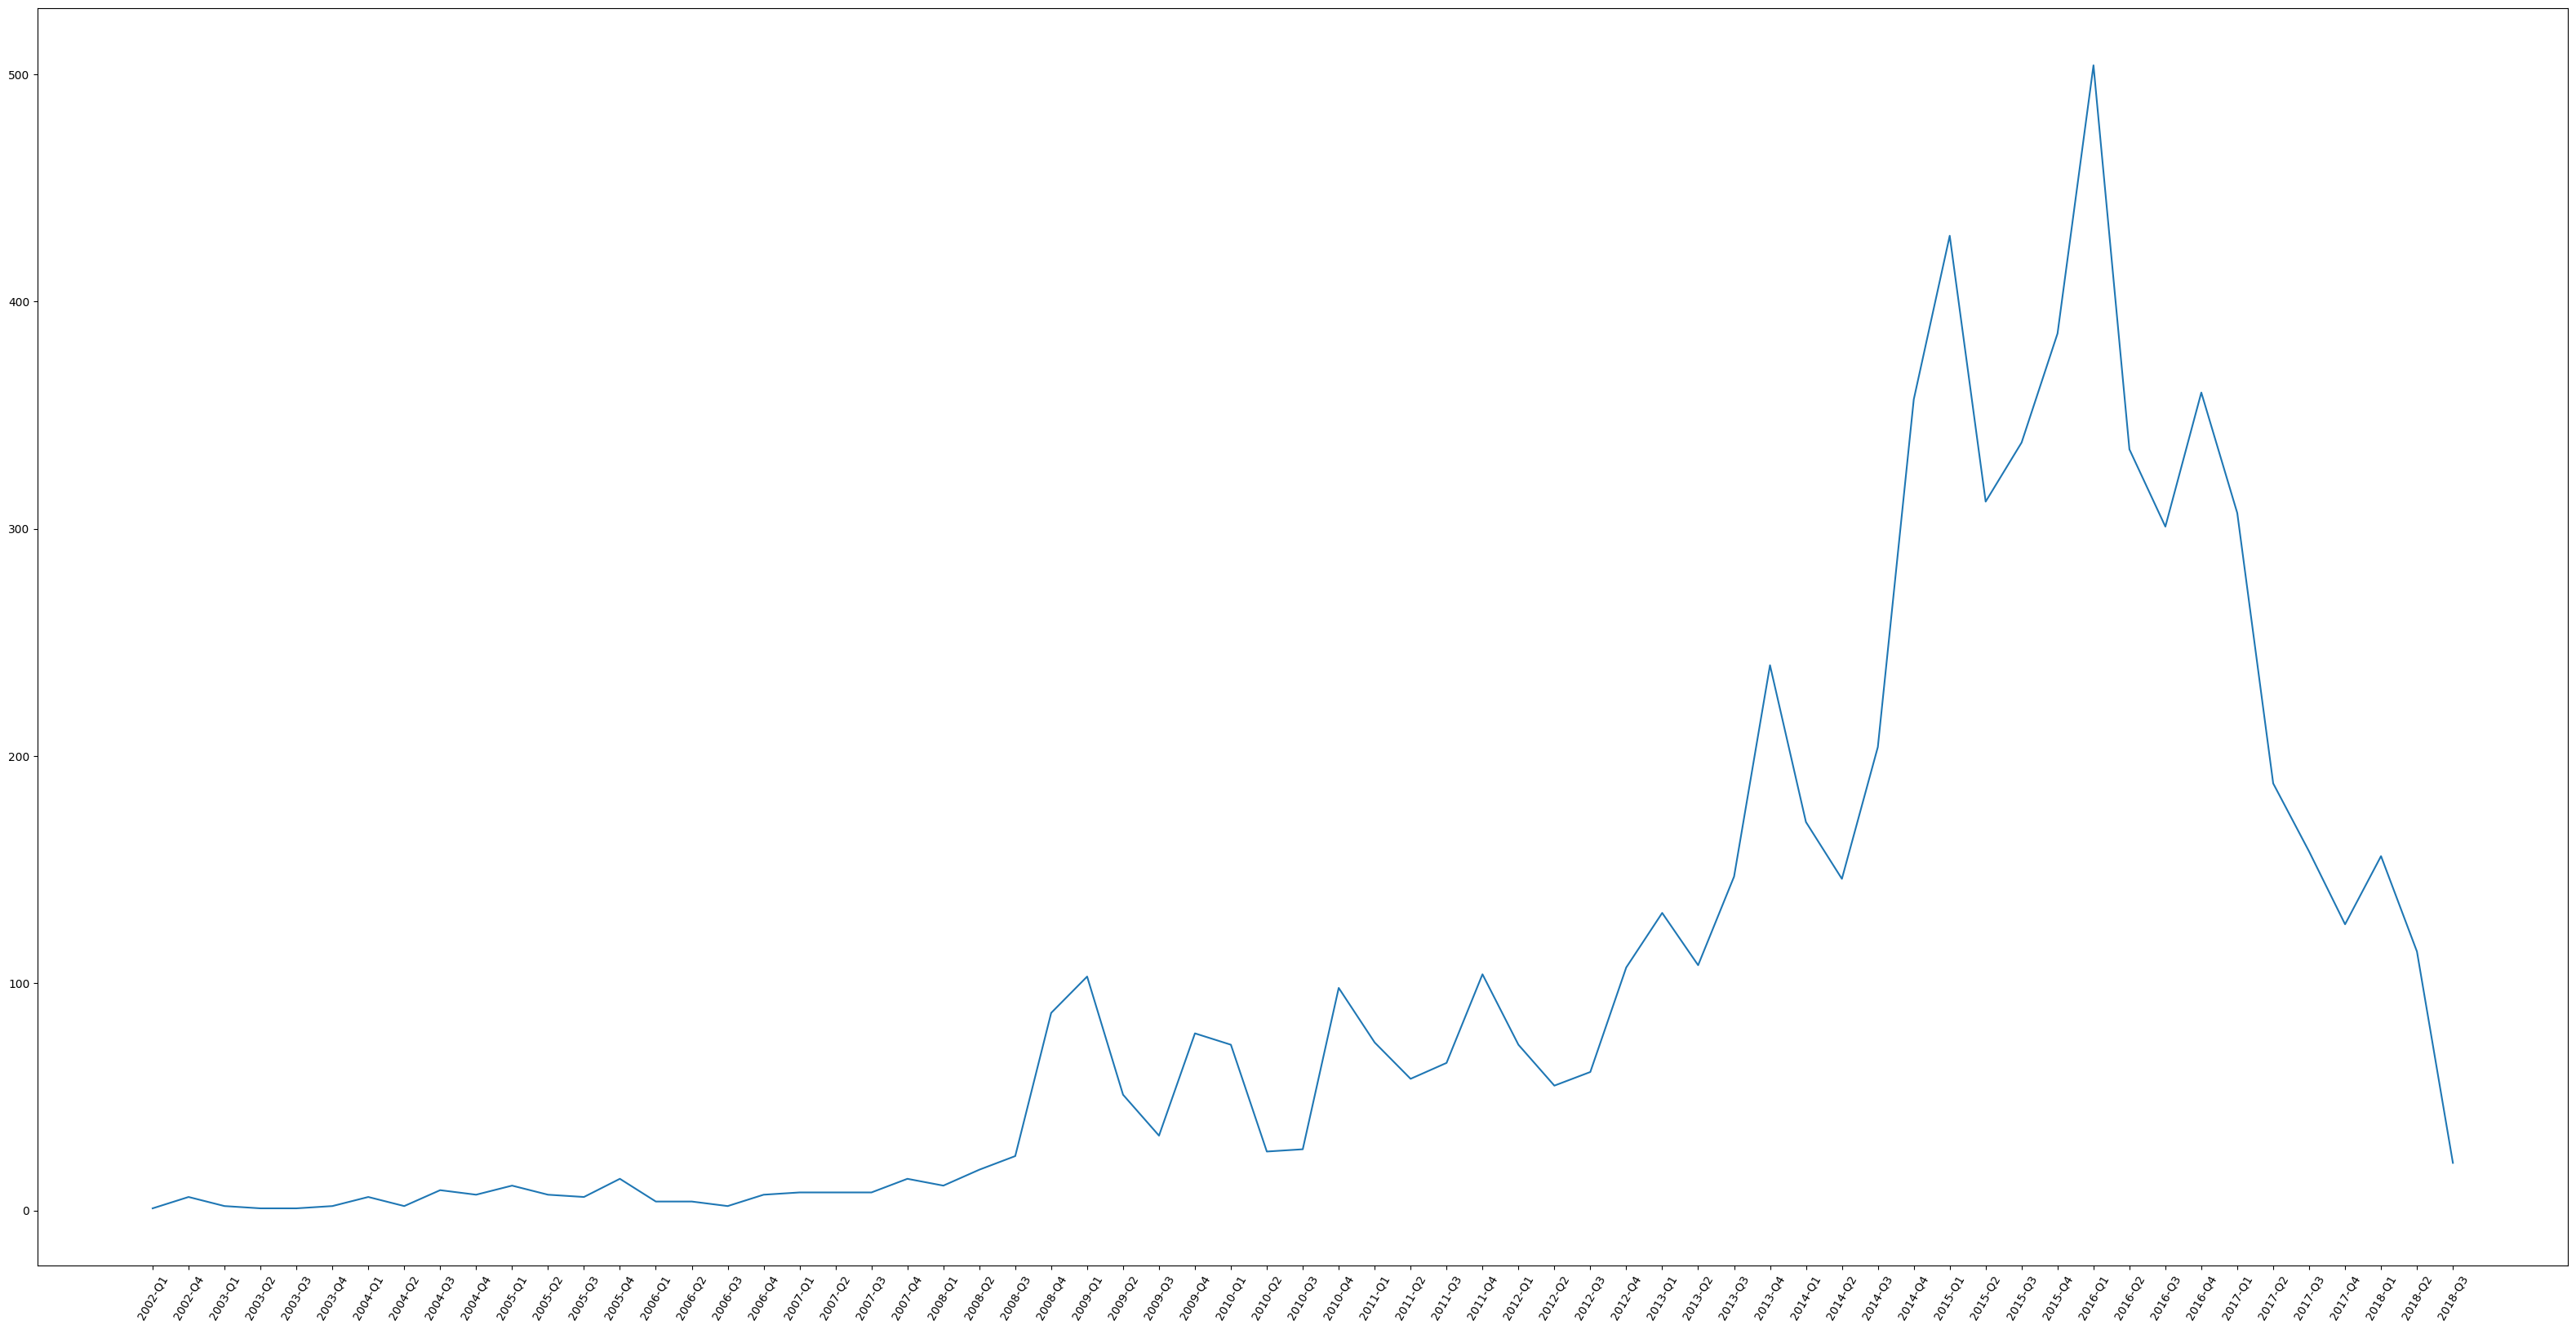

In [19]:
plt.figure(figsize = (40, 20))
plt.plot(test['year-q'].value_counts().sort_index().index, test['year-q'].value_counts().sort_index().values)
plt.xticks(rotation=60)

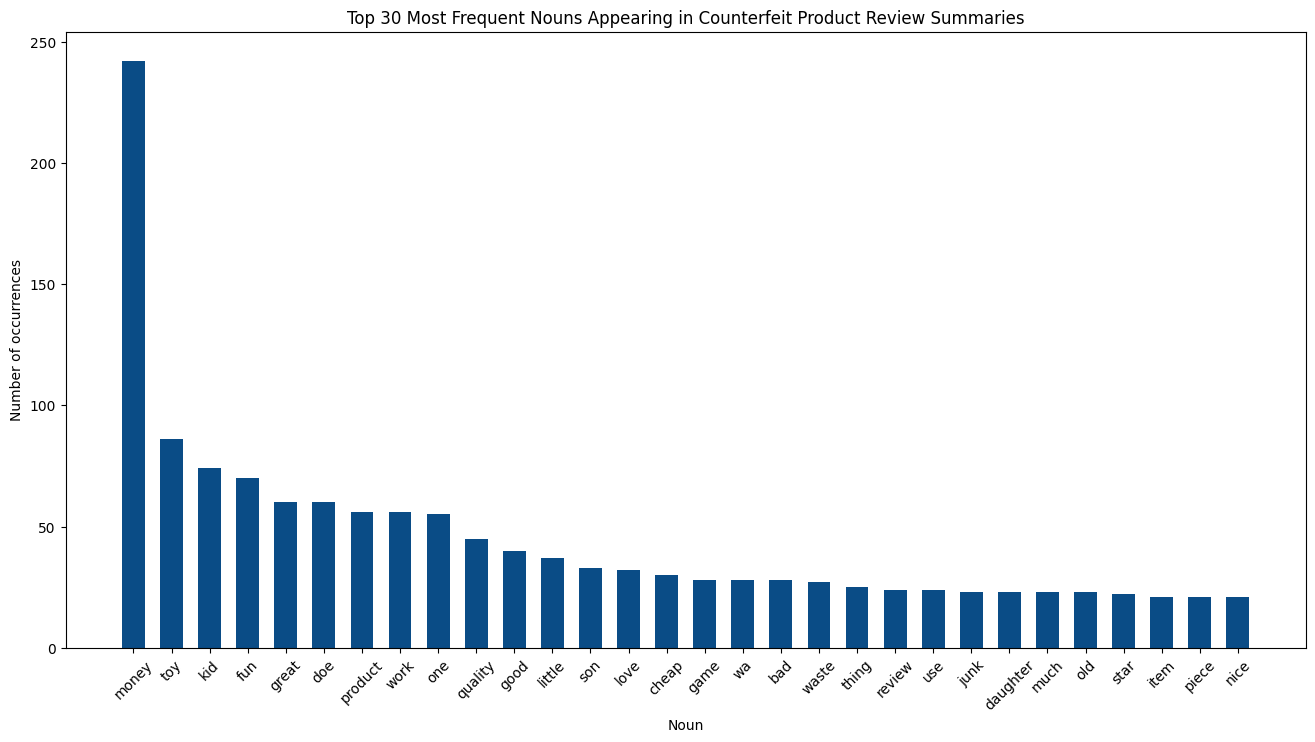

In [20]:
nouns = sub + at
top_20_subjects = pd.Series(nouns).value_counts().head(30)
values = top_20_subjects.values
words = top_20_subjects.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='#0a4c86', width = 0.6)

plt.xlabel("Noun")
plt.ylabel("Number of occurrences")
plt.title("Top 30 Most Frequent Nouns Appearing in Counterfeit Product Review Summaries")
plt.xticks(rotation=45)
plt.show()

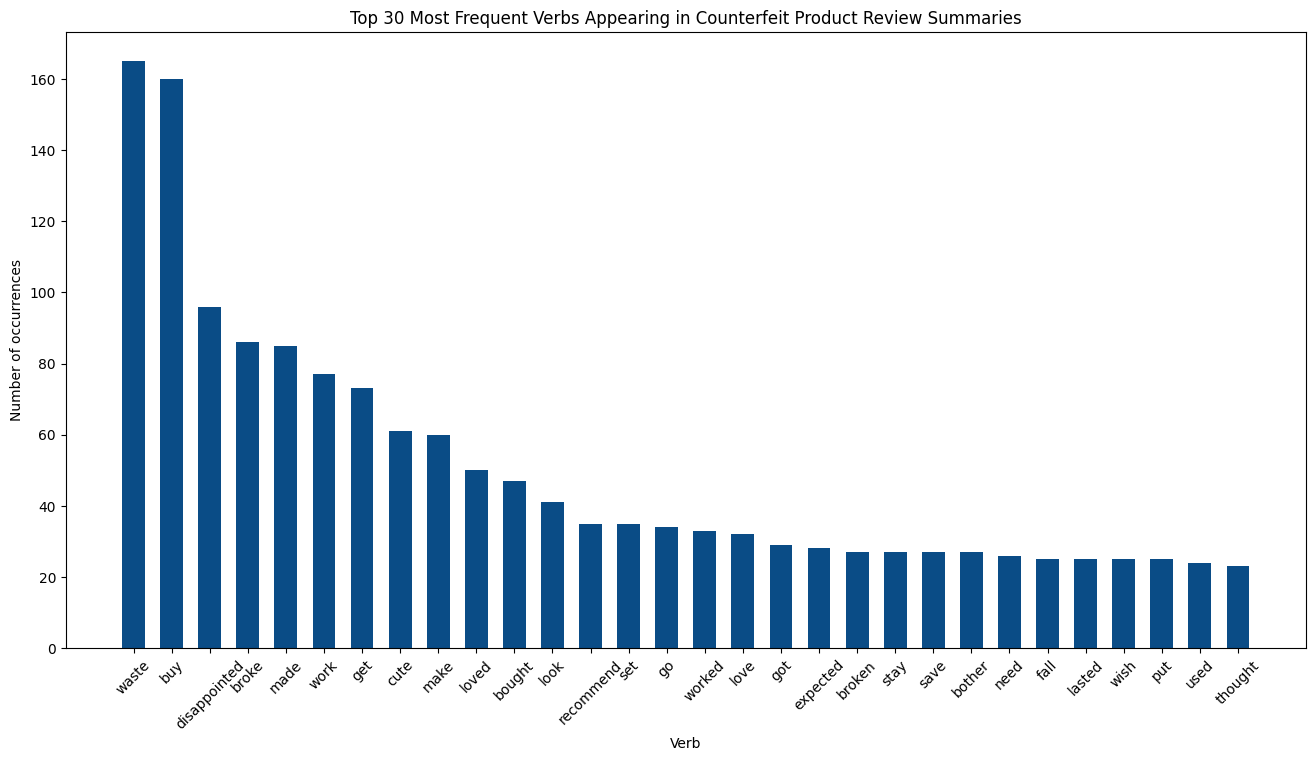

In [21]:
top_20_subjects = pd.Series(ve).value_counts().head(30)
values = top_20_subjects.values
words = top_20_subjects.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='#0a4c86', width = 0.6)

plt.xlabel("Verb")
plt.ylabel("Number of occurrences")
plt.title("Top 30 Most Frequent Verbs Appearing in Counterfeit Product Review Summaries")
plt.xticks(rotation=45)
plt.show()

Examining the average score for the counterfeit items and the overall data set over time. 

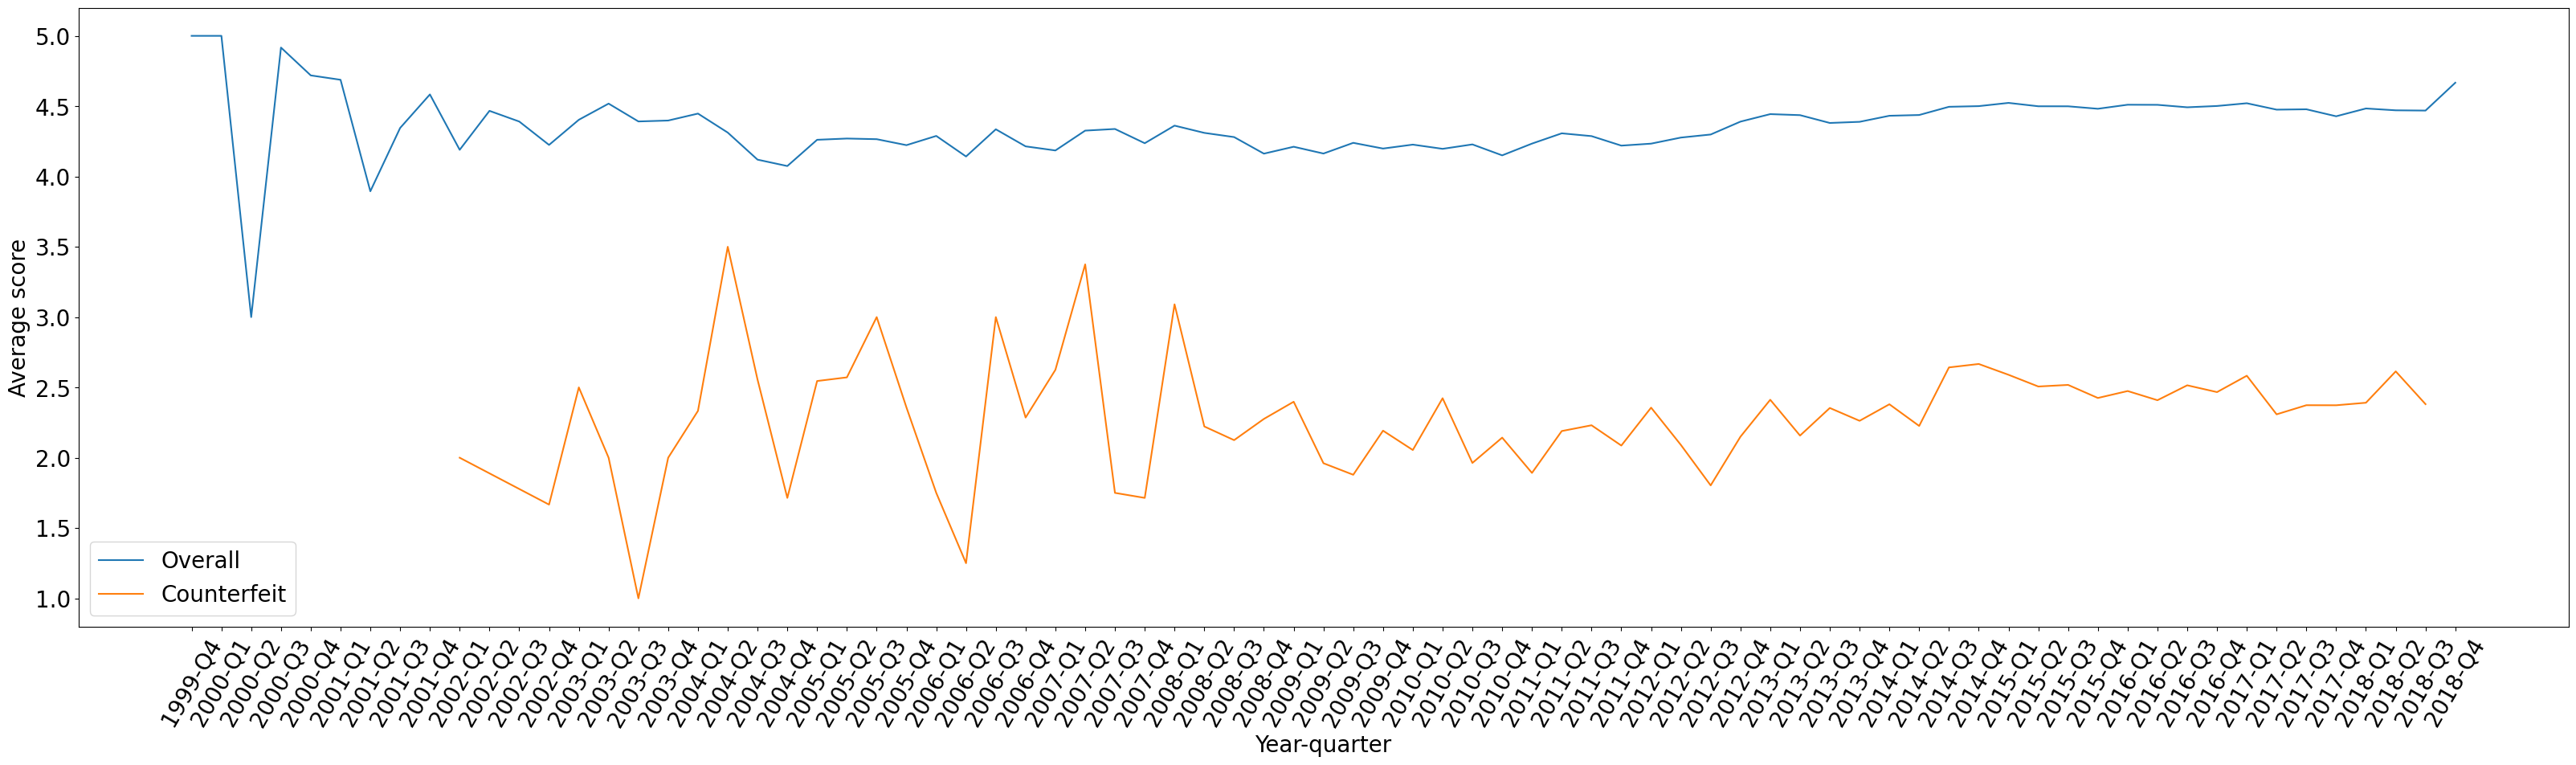

In [22]:
time_series = test.groupby(by='year-q')['overall'].mean()
overall_time_series = data_clean.groupby(by='year-q')['overall'].mean()

plt.figure(figsize = (40, 10))
plt.plot(overall_time_series.index, overall_time_series.values, label='Overall')
plt.plot(time_series.index, time_series.values, label='Counterfeit')

plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Year-quarter', fontdict={'size': 20})
plt.ylabel('Average score', fontdict={'size': 20})

plt.legend(fontsize=20)
plt.show()

CONCLUSION: The counterfeit issue is not based in reality as these toys make up a miniscule portion of the overall data set.

SECOND QUESTION: Which toys should Hasbro focus on promoting and which should it divest from producing?

***START HERE***

Visualizing the correlation between overall score and number of reviews left to find a cutoff for examining the "best" toys. Idea is people are more likely to leave bad reviews than good ones, so review "popularity" might be a better indicator of which are the best/most purchased.

To find the "best" toys, let's only look at items with an average rating over 4 stars. What should the total review cutoff be?

Chart showing the distribution of total reviews across all the Hasbro items:

In [23]:
real_hasbro['reviewType'] = np.where(real_hasbro['overall']< 3, 1, 0)
all_reviews = real_hasbro.groupby('asin')['overall'].count()
neg_reviews = real_hasbro.groupby('asin')['reviewType'].sum().values/all_reviews.values
ver_reviewers = real_hasbro.groupby('asin')['verified'].sum().values/all_reviews.values
avg_score = real_hasbro.groupby('asin')['overall'].mean().values
votes = real_hasbro.groupby('asin')['vote'].mean().values

d = {'asin': all_reviews.index, 'neg_ratio': neg_reviews, 'ver_ratio': ver_reviewers, 'avg_score': avg_score, 'avg_votes': votes, 'total': all_reviews.values}
ratio_data = pd.DataFrame(d)

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/1221470011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_hasbro['reviewType'] = np.where(real_hasbro['overall']< 3, 1, 0)


/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/1075352957.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Products by Number of Reviews for Hasbro Products with Average Rating Above 4')

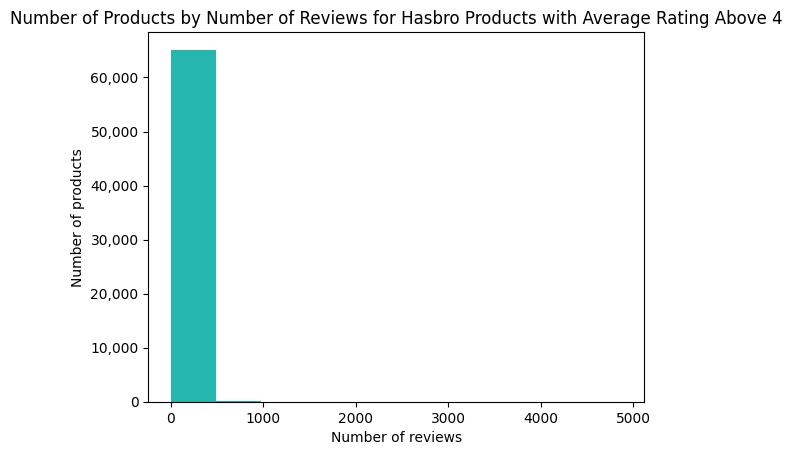

In [24]:
plt.hist(ratio_data[ratio_data['avg_score'] > 4]['total'], color='#26b6b0')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Number of reviews')
plt.ylabel('Number of products')
plt.title('Number of Products by Number of Reviews for Hasbro Products with Average Rating Above 4')

Let's zoom in on a smaller range of votes to find a reasonable cutoff point:

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/1120121925.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Products by Number of Reviews for Hasbro Products with Average Rating Above 4')

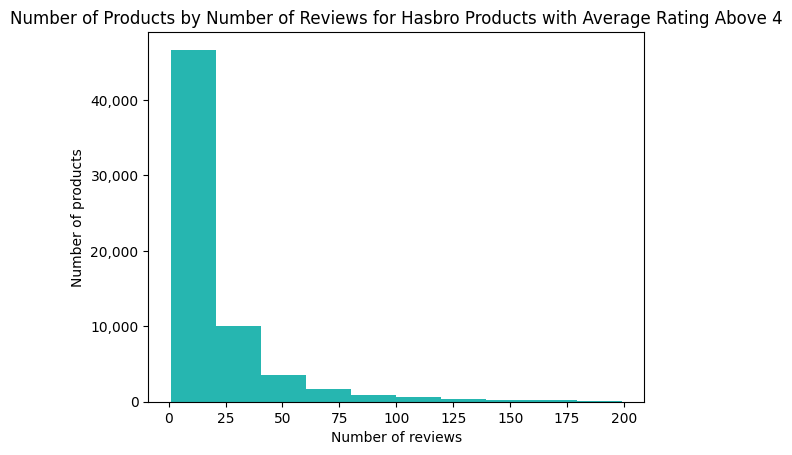

In [25]:
plt.hist(ratio_data[(ratio_data['avg_score'] > 4) & (ratio_data['total'] < 200)]['total'], color='#26b6b0')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Number of reviews')
plt.ylabel('Number of products')
plt.title('Number of Products by Number of Reviews for Hasbro Products with Average Rating Above 4')

100 reviews seems to be a good cutoff point, as the bin size is noticably bigger under that threshold. 

In [26]:
keep_asins = ratio_data[(ratio_data['avg_score'] > 4) & (ratio_data['total'] > 100)]['asin']
best_toys = data_clean[data_clean['asin'].isin(keep_asins)]

Looking at the Hasbro items that have an average rating of over 4 stars and over 100 reviews - only around 6% of the reviews for this group (2326 items) are below 3 stars.

In [27]:
print('number of items: ', len(best_toys['asin'].unique()))
best_toys['overall'].value_counts()/len(best_toys) * 100

number of items:  2326


overall
5    74.760365
4    14.169814
3     6.228909
2     2.491162
1     2.349751
Name: count, dtype: float64

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/2982388908.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Reviews for Most Popular Hasbro Products Over Time')

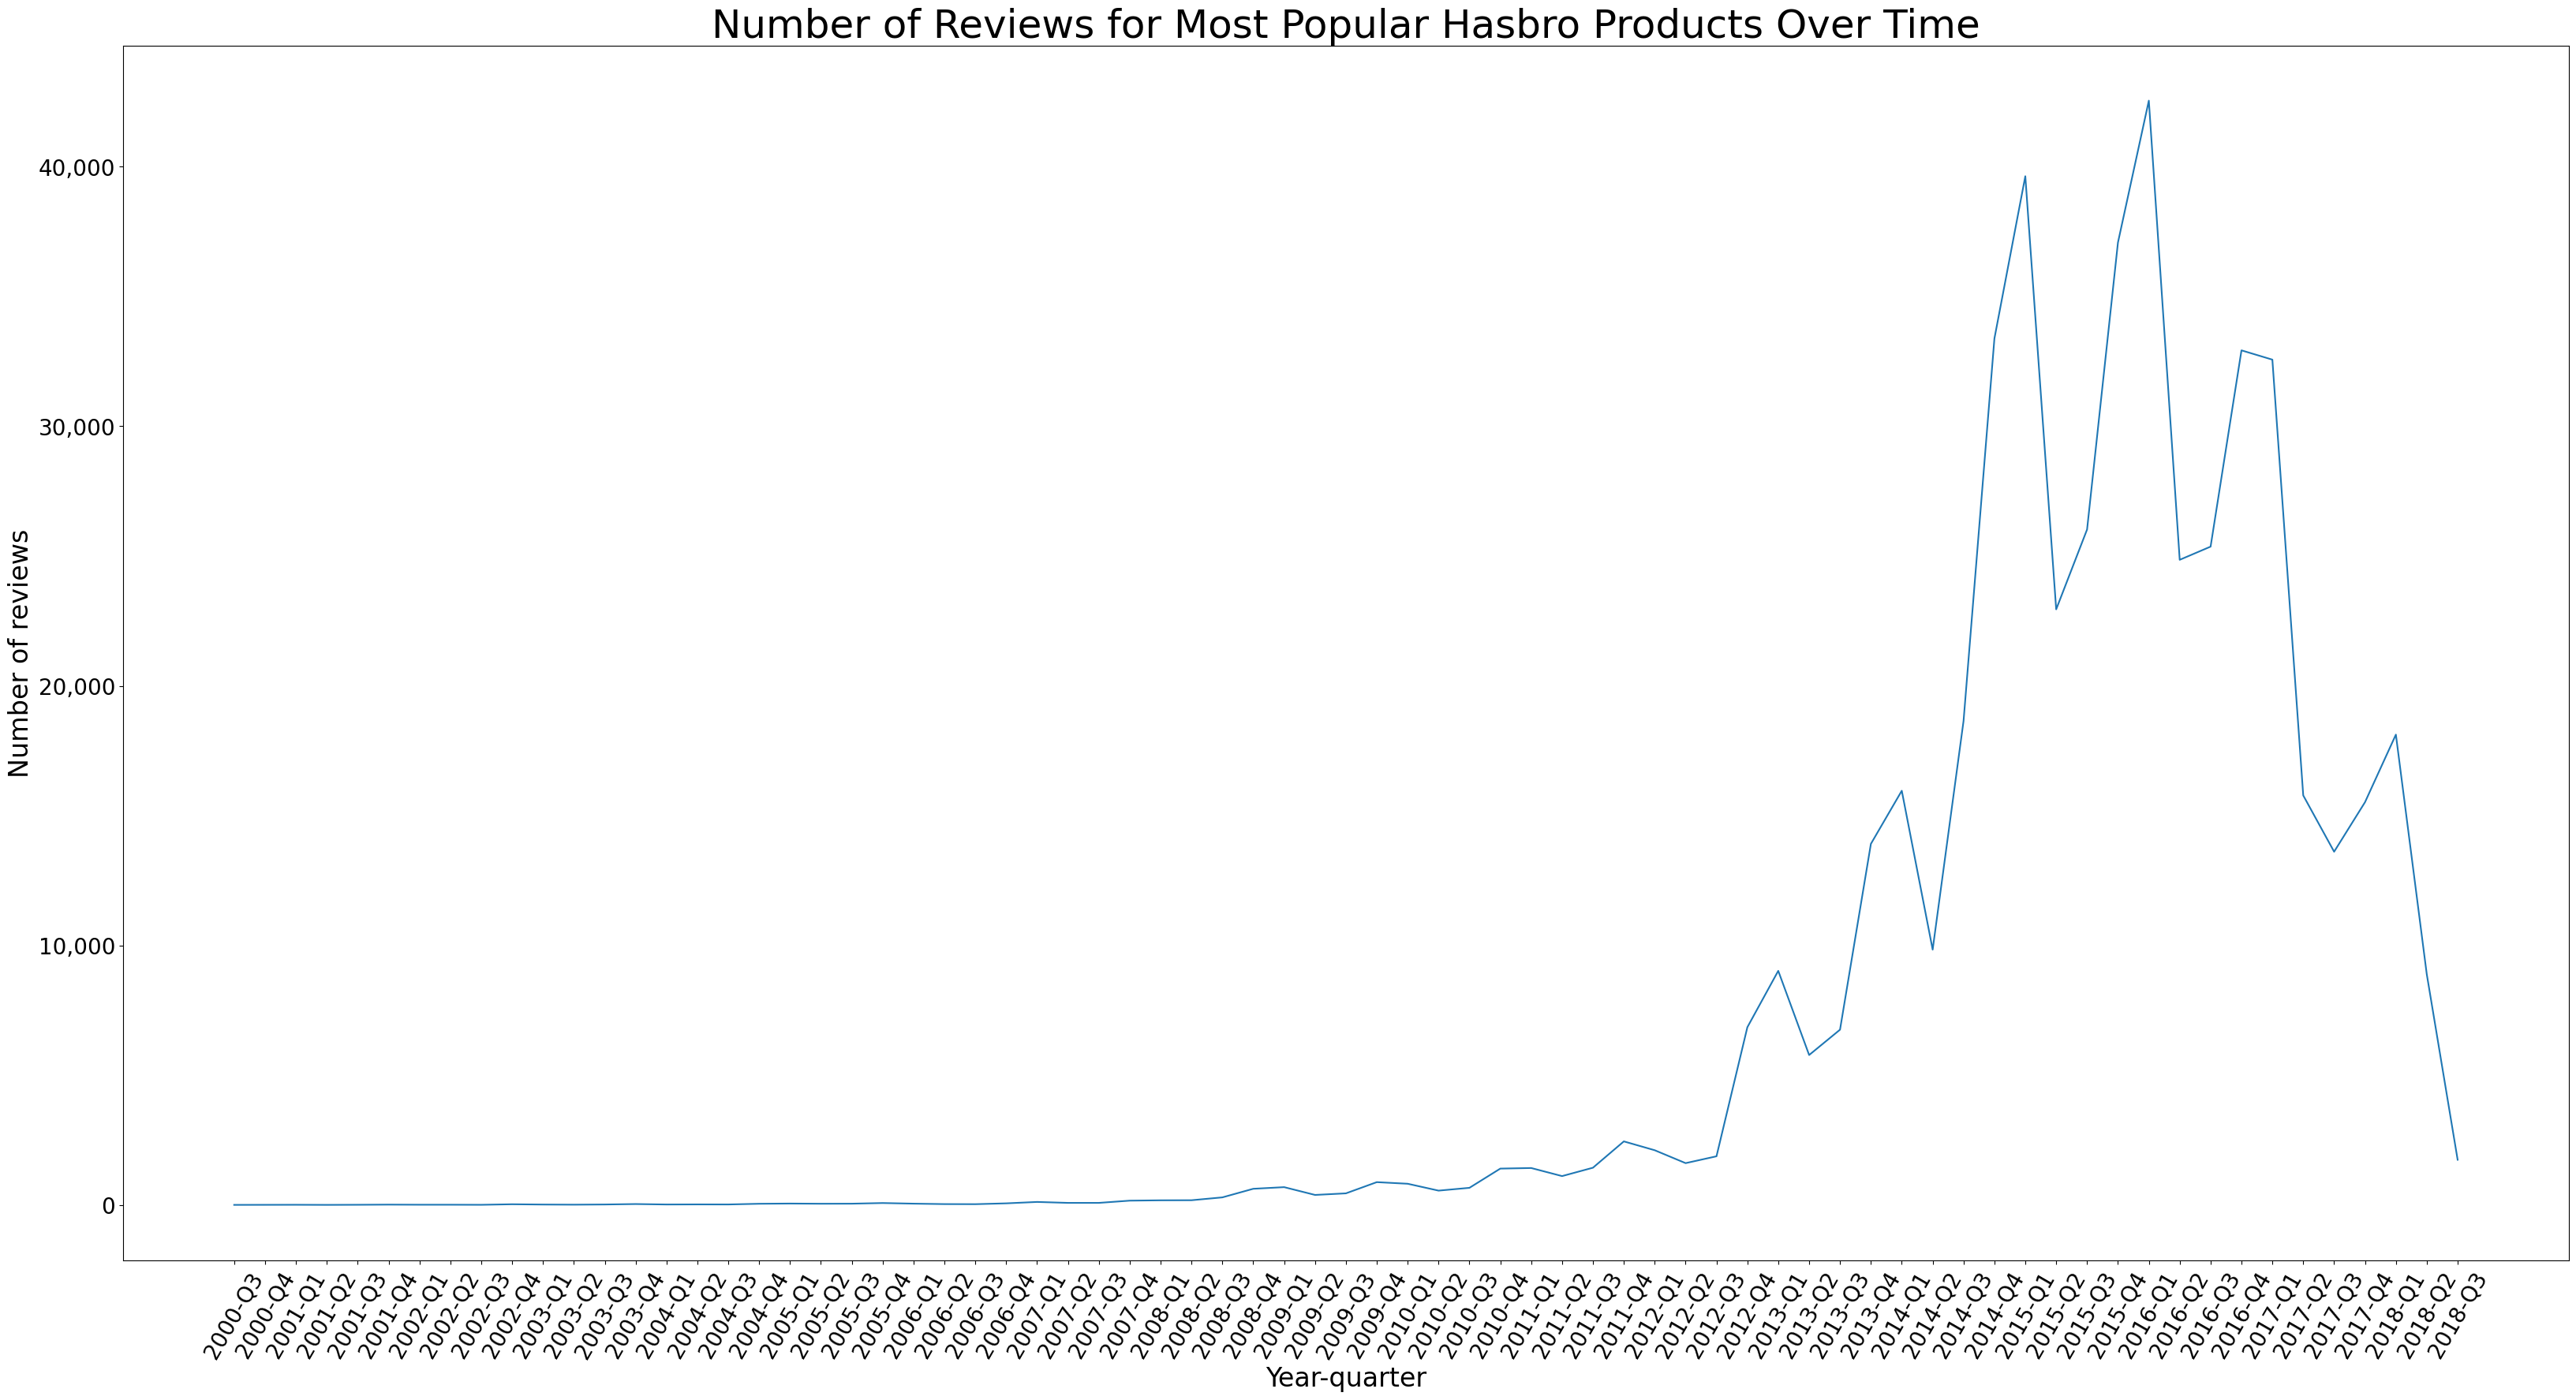

In [28]:
plt.figure(figsize = (40, 20))
plt.plot(best_toys['year-q'].value_counts().sort_index().index, best_toys['year-q'].value_counts().sort_index().values)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Year-quarter', fontdict={'size': 24})
plt.ylabel('Number of reviews', fontdict={'size': 24})
plt.title('Number of Reviews for Most Popular Hasbro Products Over Time', fontdict={'size': 36})

Worst toys

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/3723280363.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Products by Number of Reviews for Hasbro Products with Average Rating Below 3')

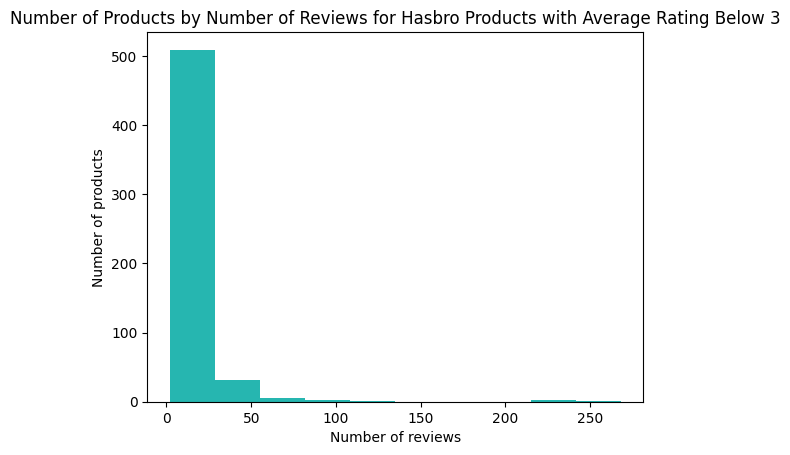

In [29]:
plt.hist(ratio_data[ratio_data['avg_score'] < 3]['total'], color='#26b6b0')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Number of reviews')
plt.ylabel('Number of products')
plt.title('Number of Products by Number of Reviews for Hasbro Products with Average Rating Below 3')

In [30]:
ratio_data[ratio_data['avg_score'] < 3]['total'].describe()

count    554.000000
mean      13.848375
std       21.309027
min        2.000000
25%        6.000000
50%        8.000000
75%       14.000000
max      268.000000
Name: total, dtype: float64

In [31]:
bad_asins = ratio_data[ratio_data['avg_score'] < 3]['asin']
worst_toys = data_clean[data_clean['asin'].isin(bad_asins)]
print('number of items: ', len(worst_toys['asin'].unique()))
worst_toys['overall'].value_counts()/len(worst_toys) * 100

number of items:  554


overall
1    31.074035
5    21.128780
3    21.024505
4    13.725235
2    13.047445
Name: count, dtype: float64

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50920/3761095630.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Number of Reviews for Least Popular Hasbro Products Over Time')

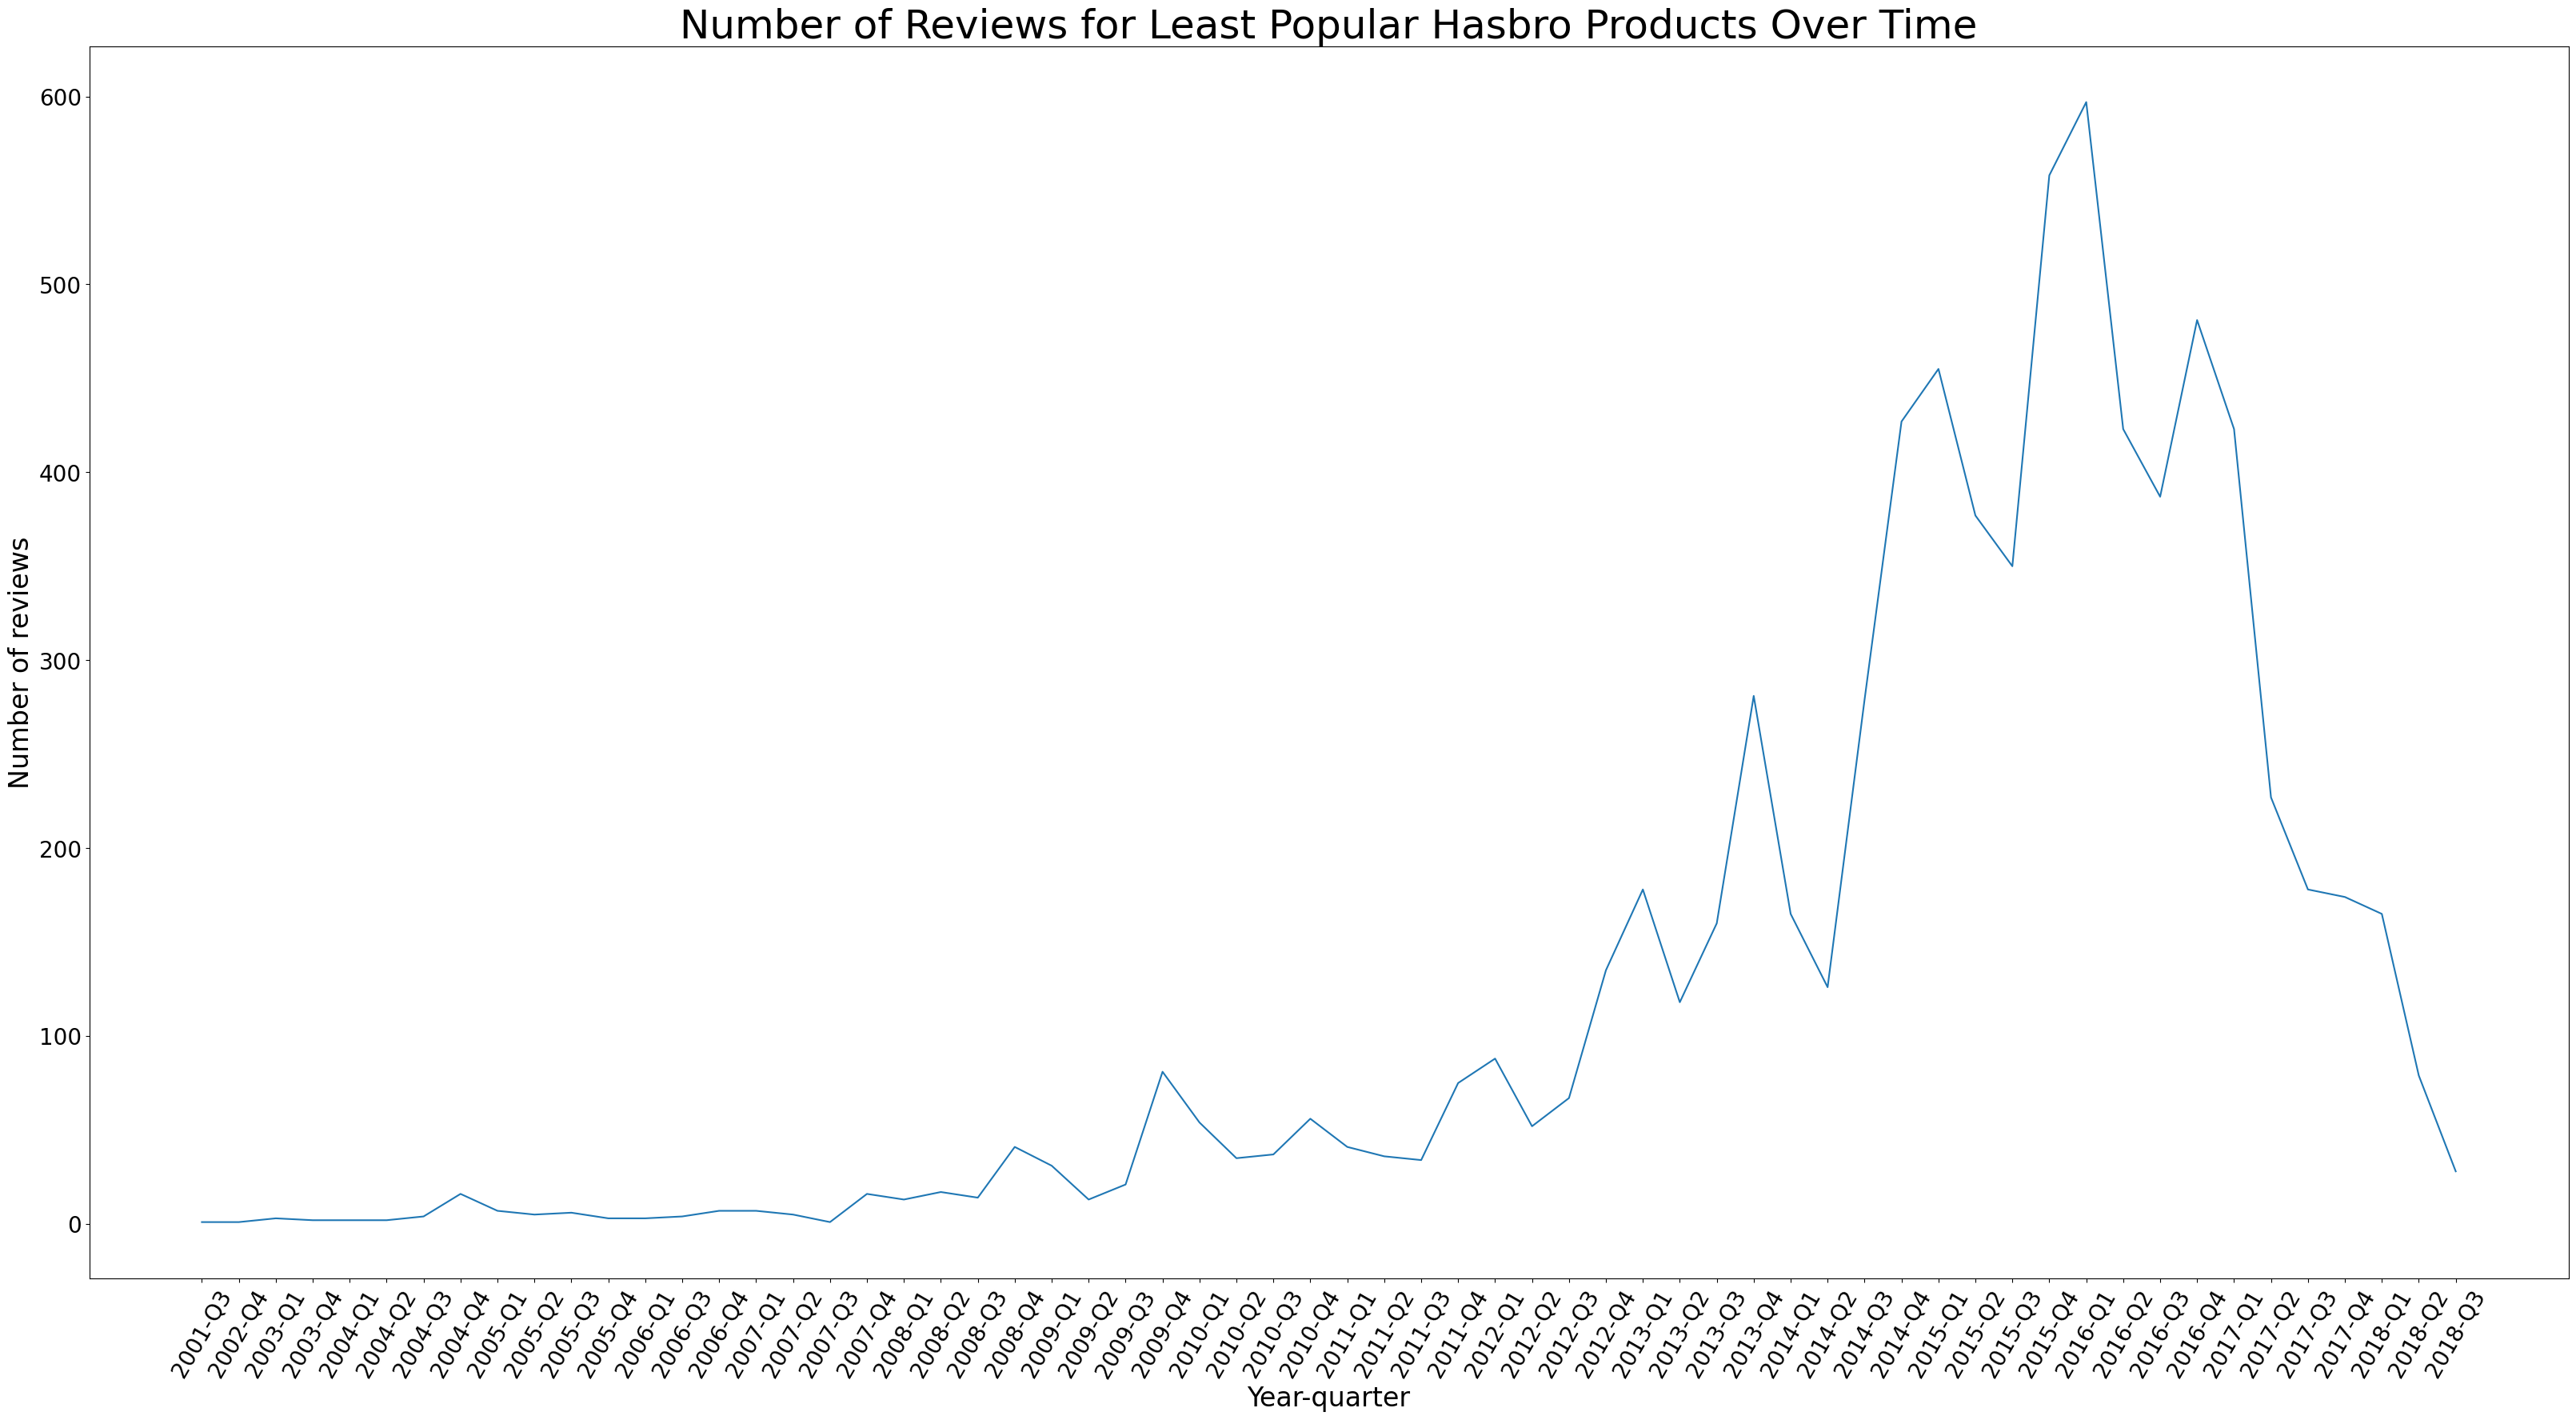

In [32]:
plt.figure(figsize = (40, 20))
plt.plot(worst_toys['year-q'].value_counts().sort_index().index, worst_toys['year-q'].value_counts().sort_index().values)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Year-quarter', fontdict={'size': 24})
plt.ylabel('Number of reviews', fontdict={'size': 24})
plt.title('Number of Reviews for Least Popular Hasbro Products Over Time', fontdict={'size': 36})

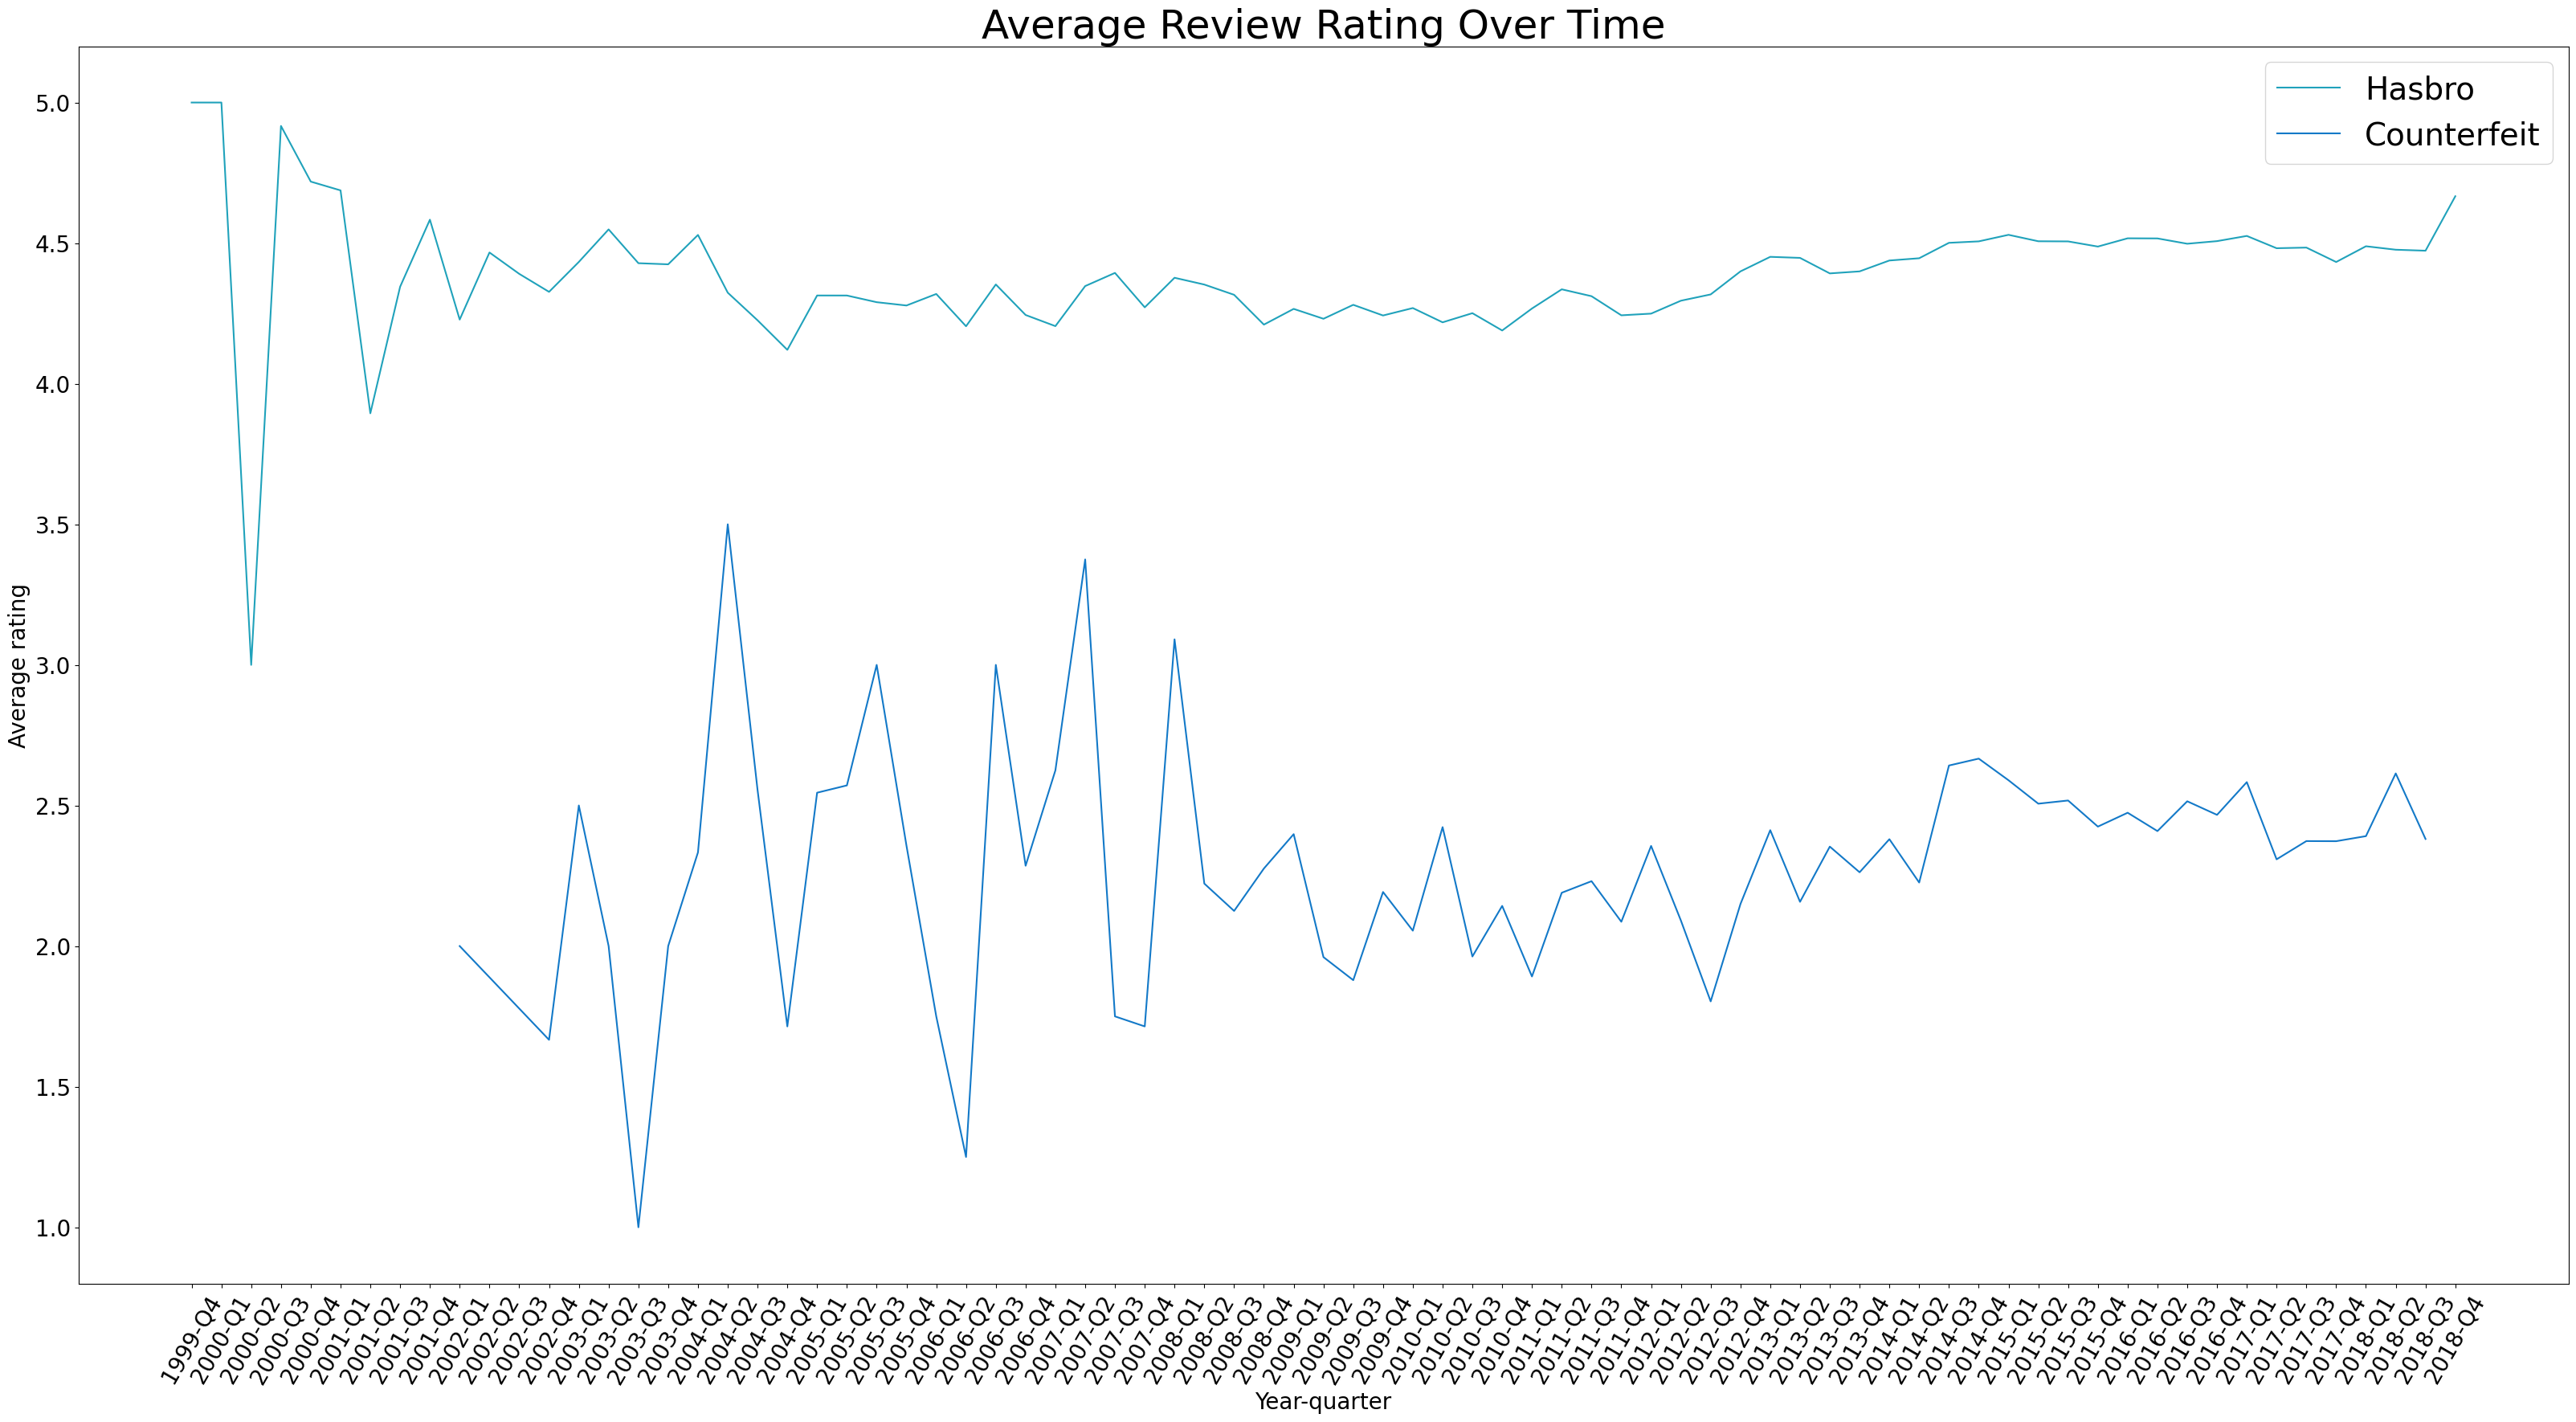

In [33]:
overall_time_series = real_hasbro.groupby(by='year-q')['overall'].mean()
overall2_time_series = test.groupby(by='year-q')['overall'].mean()

plt.figure(figsize = (40, 20))
plt.plot(overall_time_series.index, overall_time_series.values, label='Hasbro', color='#20a2bb')
plt.plot(overall2_time_series.index, overall2_time_series.values, label='Counterfeit', color='#1379c8')

plt.xlabel("Year-quarter", fontdict={'size': 20})
plt.ylabel("Average rating", fontdict={'size': 20})
plt.title("Average Review Rating Over Time", fontdict={'size': 36})

plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=28)
plt.show()

In [34]:
word_list = [x.split() for x in worst_toys['cleaned_review']]
for i in range(3, 9):
    create_topic_model(word_list, i)